In [ ]:
!pip install datawig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 메서드 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import datawig

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# ... 없이 다 보게 하기
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# 코랩 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT = '/content/drive/MyDrive/2022빅콘/data/'

In [ ]:
# 데이터 불러오기
df = pd.read_csv(ROOT + 'merge_user_loan_3.csv')

In [ ]:
# 데이터 불러오기
# df = pd.read_csv(ROOT + 'DoingNaN.csv')

In [ ]:
df.shape

(13519842, 24)

In [ ]:
# 칼럼명 한글로 바꾸어주기
df.columns = ['신청서 번호','한도조회 일시','금융사 번호','상품 번호','승인한도','승인금리','신청 여부(타겟)','유저 번호',
              '생년월일','성별','생성일시','신용점수','연소득','근로형태','입사연월','고용형태','주거소유형태','대출희망금액',
              '대출목적','개인회생자 여부','개인회생자 납입 완료 여부','기대출수','기대출금액','날짜']

In [ ]:
# 근로 형태 값 한글로 바꾸기
df['근로형태'].value_counts()

EARNEDINCOME       11463318
EARNEDINCOME2        563960
PRIVATEBUSINESS      493081
OTHERINCOME          401703
FREELANCER           312487
PRACTITIONER         285293
Name: 근로형태, dtype: int64

In [ ]:
df['근로형태'] = df['근로형태'].replace('EARNEDINCOME','직장가입자(4대보험O)').replace('EARNEDINCOME2','직장가입자(4대보험X)').replace('PRIVATEBUSINESS','개인사업자').replace('OTHERINCOME','기타소득').replace('FREELANCER','프리랜서').replace('PRACTITIONER','전문직')
df['근로형태'].value_counts()

직장가입자(4대보험O)    11463318
직장가입자(4대보험X)      563960
개인사업자             493081
기타소득              401703
프리랜서              312487
전문직               285293
Name: 근로형태, dtype: int64

In [ ]:
# 결측치 확인
df.isna().sum().sort_values(ascending=False)

개인회생자 납입 완료 여부    11787469
개인회생자 여부           5885903
기대출금액              3888717
신청 여부(타겟)          3255466
기대출수               2684722
신용점수               1508618
입사연월                399201
생년월일                108176
성별                  108176
신청서 번호                   0
대출목적                     0
대출희망금액                   0
주거소유형태                   0
고용형태                     0
연소득                      0
근로형태                     0
한도조회 일시                  0
생성일시                     0
유저 번호                    0
승인금리                     0
승인한도                     0
상품 번호                    0
금융사 번호                   0
날짜                       0
dtype: int64

In [ ]:
# 나이 변수 만들기
df['연령'] = df['생년월일'].apply(lambda x: datetime.datetime.now().year - x + 1)

In [ ]:
# 나이 변수 생성했으니 생년월일 칼럼 제거
df.drop(['생년월일'], axis=1, inplace=True)

In [ ]:
# 나이 변수로 연령대 변수 생성
bins = [19,29,39,49,59,69,89,99]  # 90세 유저 한명이기에 80대에 포함시킴킴
labels = ['20대','30대','40대','50대','60대','70대','80대 이상']

df['연령대'] = pd.cut(df['연령'], bins=bins, labels=labels)

In [ ]:
# 신용점수로 신용등급 변수 생성
bins = [0,334,453,529,629,697,767,831,890,941,1000]
labels = ['10등급','9등급','8등급','7등급','6등급','5등급','4등급','3등급','2등급','1등급']

df['신용등급'] = pd.cut(df['신용점수'], bins=bins, labels=labels)

In [ ]:
# 기대출수의 결측치는 0일 것으로 판단 
df['기대출수'].fillna(0, inplace=True)

In [ ]:
# 기대출금액도 마찬가지로 0으로 결측치 채움
df.loc[df['기대출수'] == 0, '기대출금액'] = 0

In [ ]:
# 기대출금액 결측치 채울 수 있는 유저 확인
list1 = []

for i in df[(df['기대출수'] == 1) & (df['기대출금액'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i) & (df['기대출수'] == 1)]['기대출금액'].value_counts()) > 0:
        list1.append(i)

print(list1)

[]


In [ ]:
df.isna().sum().sort_values(ascending=False)

개인회생자 납입 완료 여부    11787469
개인회생자 여부           5885903
신청 여부(타겟)          3255466
신용점수               1508618
기대출금액              1203995
입사연월                399201
연령                  108176
성별                  108176
고용형태                     0
날짜                       0
기대출수                     0
대출목적                     0
대출희망금액                   0
주거소유형태                   0
신청서 번호                   0
한도조회 일시                  0
연소득                      0
생성일시                     0
유저 번호                    0
승인금리                     0
승인한도                     0
상품 번호                    0
금융사 번호                   0
근로형태                     0
dtype: int64

In [ ]:
# 형식 통일
df['입사연월'].fillna(99999999, inplace = True)
df['입사연월'] = df['입사연월'].astype(int).astype(str)
df.loc[df['입사연월'].str.len() == 6, '입사연월'] = df['입사연월'] + '01'
df.loc[df['입사연월']== '99999999', '입사연월'] = None
df['입사연월'] = pd.to_datetime(df['입사연월'])
df['생성일시'] = pd.to_datetime(df['생성일시'])

In [ ]:
df['근속월수'] = (df['생성일시'].dt.year - df['입사연월'].dt.year)*12 + df['생성일시'].dt.month - df['입사연월'].dt.month

In [ ]:
df['근속월수'].isna().sum()

399201

In [ ]:
# 근속월수 만들었으니 입사연월 제거
df.drop(['입사연월'], axis=1, inplace=True)

#### **근속월수**

In [ ]:
# 근속월수 결측치인 유저 수 확인
len(df[df['근속월수'].isna()]['유저 번호'].unique())

42552

In [ ]:
# 근속월수 결측치 채울 수 있는 유저 확인
list1 = []
list2 = []

for i in df[(df['근속월수'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i)]['근속월수'].value_counts()) > 1:
        list2.append(i)
    elif len(df[(df['유저 번호'] == i)]['근속월수'].value_counts()) == 1:
        list1.append(i)

print(list1)
print(list2)

[787153.0, 685857.0, 199243.0, 640238.0, 64380.0, 294992.0, 23514.0, 70709.0, 500659.0, 247844.0, 629950.0, 691928.0, 771865.0, 329525.0, 93364.0, 318759.0, 841352.0, 338779.0, 834544.0, 379504.0, 443707.0, 555508.0, 210399.0, 68895.0, 292160.0, 357229.0, 293244.0, 549677.0, 432151.0, 412131.0, 865617.0, 229616.0, 455160.0, 101462.0, 124613.0, 412357.0, 85744.0, 90833.0, 796136.0, 562552.0, 757622.0, 474468.0, 181578.0, 47108.0, 461558.0, 108030.0, 91479.0, 378504.0, 3396.0, 563109.0, 439497.0, 330408.0, 421715.0, 754132.0, 837526.0, 402444.0, 737804.0, 716844.0, 755479.0, 838362.0, 260273.0, 555224.0, 223025.0, 521150.0, 454395.0, 424350.0, 16964.0, 832714.0, 108677.0, 612767.0, 156211.0, 234835.0, 720104.0, 286405.0, 266672.0, 543657.0, 677056.0, 524351.0, 70924.0, 652339.0, 386302.0, 576220.0, 194918.0, 721954.0, 704283.0, 516743.0, 503627.0, 89530.0, 727660.0, 288174.0, 48654.0, 839028.0, 468046.0, 629448.0, 481795.0, 597999.0, 541478.0, 680645.0, 293300.0, 286204.0, 134000.0, 5029

In [ ]:
len(list1)

5857

In [ ]:
len(list2)

4084

In [ ]:
# 근속월수 변함 없는 유저들 결측치 채우기
df.loc[df['유저 번호'].isin(list1),'근속월수'] = df.loc[df['유저 번호'].isin(list1)].groupby('유저 번호')['근속월수'].transform('max')

In [ ]:
df.loc[df['유저 번호'].isin(list1)][:5]

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,...,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수
453,1029177,2022-06-07 13:35:01,63,226,10000000.0,18.7,NaN,787153.0,1.0,2022-06-07 13:34:58,...,전월세,5000000.0,생활비,0.0,NaN,5.0,12000000.0,2022-06-07,46.0,2.0
454,1029177,2022-06-07 13:34:59,24,229,15000000.0,9.4,NaN,787153.0,1.0,2022-06-07 13:34:58,...,전월세,5000000.0,생활비,0.0,NaN,5.0,12000000.0,2022-06-07,46.0,2.0
455,1545691,2022-06-07 14:18:15,13,123,15000000.0,20.0,NaN,787153.0,1.0,2022-06-07 14:18:14,...,전월세,2000000.0,생활비,0.0,NaN,5.0,12000000.0,2022-06-07,46.0,2.0
456,1029177,2022-06-07 13:34:59,51,247,36000000.0,18.9,NaN,787153.0,1.0,2022-06-07 13:34:58,...,전월세,5000000.0,생활비,0.0,NaN,5.0,12000000.0,2022-06-07,46.0,2.0
457,1029177,2022-06-07 13:35:00,54,259,38000000.0,15.9,NaN,787153.0,1.0,2022-06-07 13:34:58,...,전월세,5000000.0,생활비,0.0,NaN,5.0,12000000.0,2022-06-07,46.0,2.0


In [ ]:
len(df[df['근속월수'].isna()])

343888

In [ ]:
df[df['근속월수'].isna()]['근로형태'].value_counts()

기타소득            343810
직장가입자(4대보험O)        55
개인사업자               23
Name: 근로형태, dtype: int64

In [ ]:
len(df[df['근로형태'] == '기타소득'])

401703

In [ ]:
df[df['근로형태'] == '기타소득']['근속월수'].isna().sum()

343810

In [ ]:
# 기타소득이면 근속월수 입력불가.. 따라서 0으로 설정
df.loc[(df['근로형태'] == '기타소득') & (df['근속월수'].isna()), '근속월수'] = 0

In [ ]:
df[df['근속월수'].isna()]['근로형태'].value_counts()

직장가입자(4대보험O)    55
개인사업자           23
Name: 근로형태, dtype: int64

##### 직장가입자의 경우

In [ ]:
# 1. 직장가입자의 경우
df[(df['근속월수'].isna()) & (df['근로형태'] == '직장가입자(4대보험O)')]['유저 번호'].unique()

array([174784., 776609., 861913.])

In [ ]:
df[df['유저 번호'] == 174784].head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
1224332,1026844,2022-04-08 15:12:09,10,149,14000000.0,15.6,0.0,174784.0,1.0,2022-04-08 15:12:08,NaN,32000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,대환대출,NaN,NaN,0.0,0.0,2022-04-08,25.0,NaN,20대,NaN
1224333,1026844,2022-04-08 15:12:11,56,5,2000000.0,19.9,0.0,174784.0,1.0,2022-04-08 15:12:08,NaN,32000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,대환대출,NaN,NaN,0.0,0.0,2022-04-08,25.0,NaN,20대,NaN
1224334,1026844,2022-04-08 15:12:10,25,169,25000000.0,19.9,0.0,174784.0,1.0,2022-04-08 15:12:08,NaN,32000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,대환대출,NaN,NaN,0.0,0.0,2022-04-08,25.0,NaN,20대,NaN
1224335,1026844,2022-04-08 15:12:10,32,56,10000000.0,17.7,0.0,174784.0,1.0,2022-04-08 15:12:08,NaN,32000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,대환대출,NaN,NaN,0.0,0.0,2022-04-08,25.0,NaN,20대,NaN
1224336,1026844,2022-04-08 15:12:10,6,36,17000000.0,18.4,0.0,174784.0,1.0,2022-04-08 15:12:08,NaN,32000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,대환대출,NaN,NaN,0.0,0.0,2022-04-08,25.0,NaN,20대,NaN


In [ ]:
# 174784 유저랑 비슷한 특징의 유저
df_sim = df[(df['연령대'] == '20대') & (df['근로형태'] == '직장가입자(4대보험O)') & (df['고용형태'] == '정규직') & (df['주거소유형태'] == '전월세') & (df['대출목적'] == '대환대출') & (df['유저 번호'].duplicated() == False)]
len(df_sim)

4377

In [ ]:
df_sim['근속월수'].isna().sum()

1

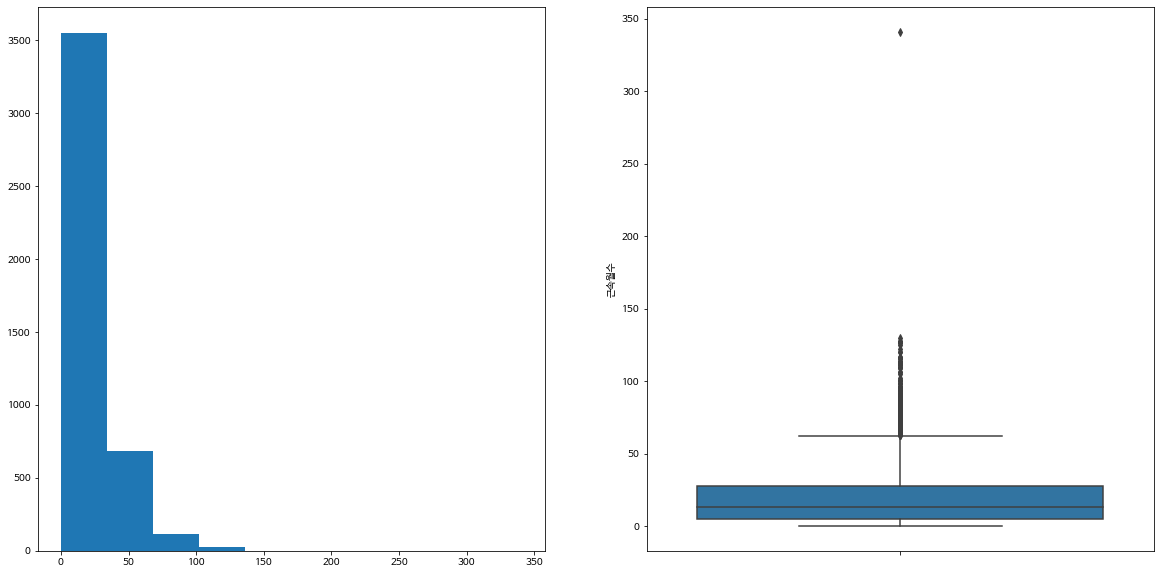

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(df_sim['근속월수'])

plt.subplot(1,2,2)
sns.boxplot(y=df_sim['근속월수'])

plt.show()

In [ ]:
df_sim['근속월수'].describe()

count    4376.000000
mean       19.478291
std        20.790129
min         0.000000
25%         5.000000
50%        13.000000
75%        28.000000
max       341.000000
Name: 근속월수, dtype: float64

In [ ]:
# 중간값으로 채움
df.loc[(df['유저 번호'] == 174784), '근속월수'] = df_sim['근속월수'].median()

In [ ]:
# 776609 유저
df[df['유저 번호'] == 776609].head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
10499984,1401966,2022-05-13 23:15:27,24,70,3000000.0,13.0,0.0,776609.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,직장가입자(4대보험O),계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2022-05-13,32.0,NaN,30대,2등급
10499985,1401966,2022-05-13 23:15:29,25,163,33000000.0,12.9,0.0,776609.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,직장가입자(4대보험O),계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2022-05-13,32.0,NaN,30대,2등급
10499986,1401966,2022-05-13 23:15:27,10,65,26000000.0,13.9,0.0,776609.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,직장가입자(4대보험O),계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2022-05-13,32.0,NaN,30대,2등급
10499987,1401966,2022-05-13 23:15:28,34,215,5000000.0,14.9,0.0,776609.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,직장가입자(4대보험O),계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2022-05-13,32.0,NaN,30대,2등급
10499988,1401966,2022-05-13 23:15:28,54,259,34000000.0,8.0,0.0,776609.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,직장가입자(4대보험O),계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2022-05-13,32.0,NaN,30대,2등급


In [ ]:
# 776609 유저랑 비슷한 특징의 유저
df_sim = df[(df['연령대'] == '30대') & (df['근로형태'] == '직장가입자(4대보험O)') & (df['고용형태'] == '계약직') & (df['주거소유형태'] == '전월세') & (df['대출목적'] == '생활비') & (df['유저 번호'].duplicated() == False)]
len(df_sim)

1334

In [ ]:
df_sim['근속월수'].isna().sum()

1

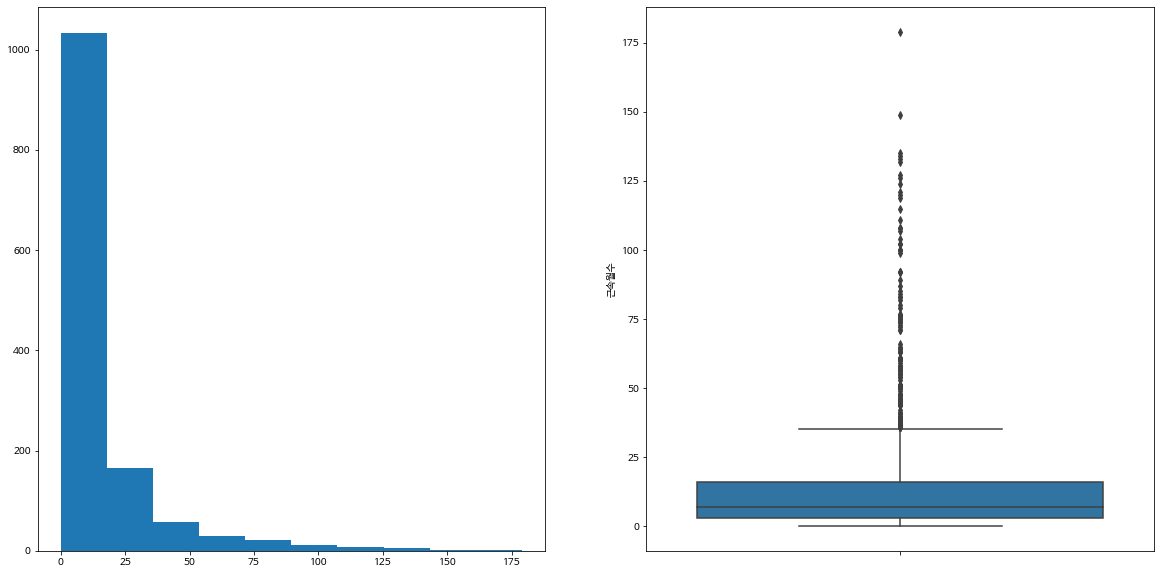

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(df_sim['근속월수'])

plt.subplot(1,2,2)
sns.boxplot(y=df_sim['근속월수'])

plt.show()

In [ ]:
df_sim['근속월수'].describe()

count    1333.000000
mean       14.470368
std        21.294695
min         0.000000
25%         3.000000
50%         7.000000
75%        16.000000
max       179.000000
Name: 근속월수, dtype: float64

In [ ]:
# 중간값으로 채움
df.loc[(df['유저 번호'] == 776609), '근속월수'] = df_sim['근속월수'].median()

In [ ]:
# 861913 유저
df[df['유저 번호'] == 861913]

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
11267247,860275,2022-05-02 16:19:58,58,175,11000000.0,14.8,0.0,861913.0,0.0,2022-05-02 16:19:56,NaN,21000000.0,직장가입자(4대보험O),정규직,전월세,20000000.0,생활비,NaN,NaN,0.0,0.0,2022-05-02,43.0,NaN,40대,NaN
11267248,860275,2022-05-02 16:19:58,6,36,8000000.0,17.7,0.0,861913.0,0.0,2022-05-02 16:19:56,NaN,21000000.0,직장가입자(4대보험O),정규직,전월세,20000000.0,생활비,NaN,NaN,0.0,0.0,2022-05-02,43.0,NaN,40대,NaN
11267249,860275,2022-05-02 16:19:57,51,247,25000000.0,18.9,0.0,861913.0,0.0,2022-05-02 16:19:56,NaN,21000000.0,직장가입자(4대보험O),정규직,전월세,20000000.0,생활비,NaN,NaN,0.0,0.0,2022-05-02,43.0,NaN,40대,NaN
11267250,860275,2022-05-02 16:19:58,32,56,5000000.0,17.7,0.0,861913.0,0.0,2022-05-02 16:19:56,NaN,21000000.0,직장가입자(4대보험O),정규직,전월세,20000000.0,생활비,NaN,NaN,0.0,0.0,2022-05-02,43.0,NaN,40대,NaN


In [ ]:
# 861913 유저랑 비슷한 특징의 유저
df_sim = df[(df['연령대'] == '40대') & (df['근로형태'] == '직장가입자(4대보험O)') & (df['고용형태'] == '정규직') & (df['주거소유형태'] == '전월세') & (df['대출목적'] == '생활비') & (df['유저 번호'].duplicated() == False)]
len(df_sim)

11250

In [ ]:
df_sim['근속월수'].isna().sum()

1

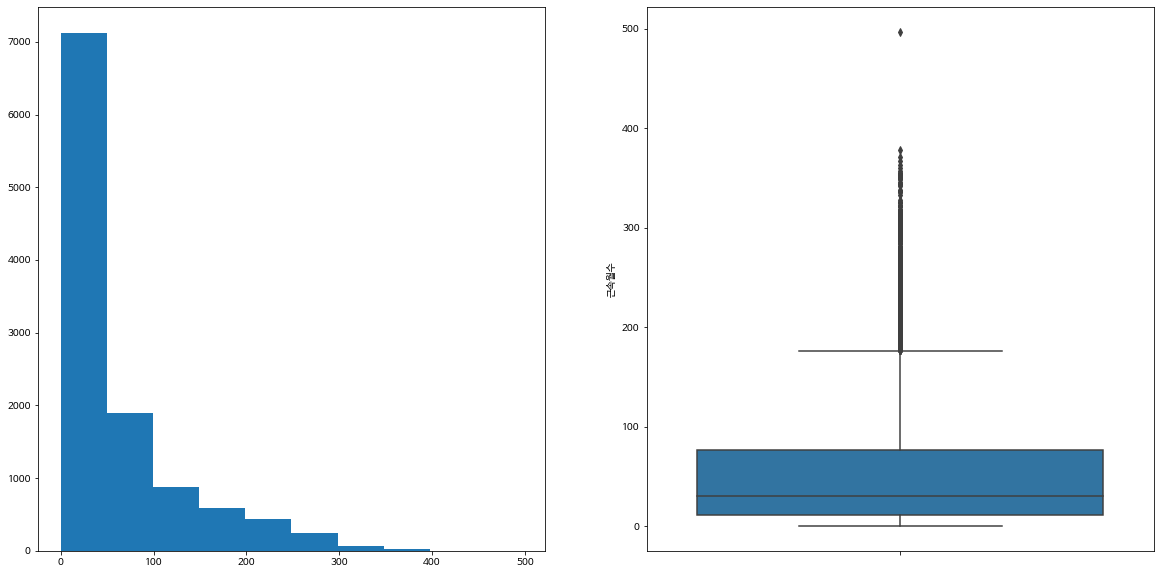

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(df_sim['근속월수'])

plt.subplot(1,2,2)
sns.boxplot(y=df_sim['근속월수'])

plt.show()

In [ ]:
df_sim['근속월수'].describe()

count    11249.000000
mean        58.638546
std         69.401683
min          0.000000
25%         11.000000
50%         30.000000
75%         77.000000
max        497.000000
Name: 근속월수, dtype: float64

In [ ]:
# 중간값으로 채움
df.loc[(df['유저 번호'] == 861913), '근속월수'] = df_sim['근속월수'].median()

##### 개인사업자의 경우

In [ ]:
# 2. 개인사업자의 경우
df[(df['근속월수'].isna()) & (df['근로형태'] == '개인사업자')]['유저 번호'].unique()

array([418233.])

In [ ]:
df[df['유저 번호'] == 418233]

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
2281287,1024494,2022-05-16 15:28:54,1,61,50000000.0,9.4,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281288,1024494,2022-05-16 15:28:54,30,85,10000000.0,13.8,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281289,1024494,2022-05-16 15:28:54,42,216,10000000.0,14.3,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281290,1024494,2022-05-16 15:28:54,29,265,30000000.0,9.3,1.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281291,1024494,2022-05-16 15:28:54,55,166,21000000.0,10.6,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281292,1024494,2022-05-16 15:28:55,15,204,11000000.0,17.3,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
2281293,1024494,2022-05-16 15:28:54,35,29,5000000.0,15.8,0.0,418233.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,개인사업자,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,2022-05-16,38.0,NaN,30대,6등급
4141138,978338,2022-04-14 18:52:20,35,107,3000000.0,14.8,0.0,418233.0,0.0,2022-04-14 18:52:19,690.0,50000000.0,개인사업자,기타,전월세,30000000.0,사업자금,NaN,NaN,3.0,20000000.0,2022-04-14,38.0,NaN,30대,6등급
4141139,978338,2022-04-14 18:52:20,1,61,50000000.0,8.9,1.0,418233.0,0.0,2022-04-14 18:52:19,690.0,50000000.0,개인사업자,기타,전월세,30000000.0,사업자금,NaN,NaN,3.0,20000000.0,2022-04-14,38.0,NaN,30대,6등급
4141140,978338,2022-04-14 18:52:48,35,29,3000000.0,15.9,0.0,418233.0,0.0,2022-04-14 18:52:19,690.0,50000000.0,개인사업자,기타,전월세,30000000.0,사업자금,NaN,NaN,3.0,20000000.0,2022-04-14,38.0,NaN,30대,6등급


In [ ]:
# 418233 유저랑 비슷한 특징의 유저
df_sim = df[(df['연령대'] == '30대') & (df['근로형태'] == '개인사업자') & (df['고용형태'] == '기타') & (df['주거소유형태'] == '전월세') & (df['유저 번호'].duplicated() == False)]
len(df_sim)

2107

In [ ]:
df_sim['근속월수'].isna().sum()

1

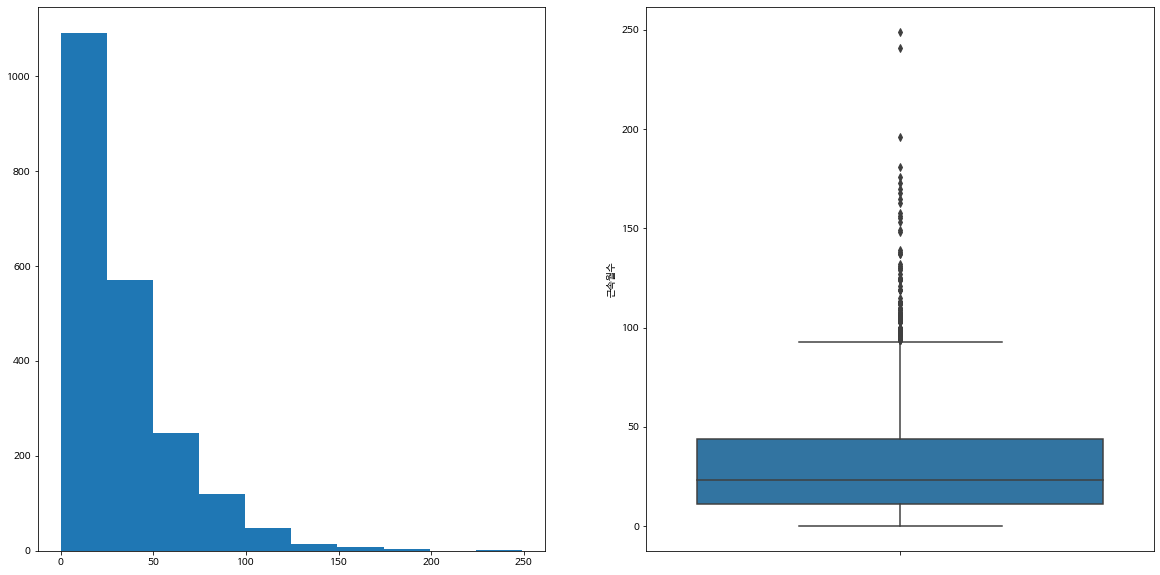

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(df_sim['근속월수'])

plt.subplot(1,2,2)
sns.boxplot(y=df_sim['근속월수'])

plt.show()

In [ ]:
df_sim['근속월수'].describe()

count    2106.000000
mean       32.018044
std        29.670217
min         0.000000
25%        11.000000
50%        23.000000
75%        44.000000
max       249.000000
Name: 근속월수, dtype: float64

In [ ]:
# 중간값으로 채움
df.loc[(df['유저 번호'] == 418233), '근속월수'] = df_sim['근속월수'].median()

#### **개인회생자**

In [ ]:
df.isna().sum().sort_values(ascending=False)

개인회생자 납입 완료 여부    11787469
개인회생자 여부           5885903
신청 여부(타겟)          3255466
신용등급               1508618
신용점수               1508618
기대출금액              1203995
연령대                 108176
연령                  108176
성별                  108176
대출희망금액                   0
근속월수                     0
날짜                       0
기대출수                     0
대출목적                     0
신청서 번호                   0
주거소유형태                   0
한도조회 일시                  0
근로형태                     0
연소득                      0
생성일시                     0
유저 번호                    0
승인금리                     0
승인한도                     0
상품 번호                    0
금융사 번호                   0
고용형태                     0
dtype: int64

In [ ]:
# 개인회생 여부가 0이면 납입완료도 0으로 설정(결측치 없애려고)
df.loc[df['개인회생자 여부'] == 0, '개인회생자 납입 완료 여부'] = 0

In [ ]:
# df.to_csv(ROOT + 'DoingNaN.csv', index=False)

In [ ]:
# '개인회생 종류' 칼럼을 만들어 개인회생자 여부, 납입완료 여부를 네가지 CASE로 구분
df['개인회생 종류'] = 'CASE4'

for a in range(df.shape[0]):
    if df.loc[a, '개인회생자 여부'] == 0:
        df.loc[a, '개인회생 종류'] = 'CASE1'
        
    elif df.loc[a, '개인회생자 여부'] == 1:
        if df.loc[a, '개인회생자 납입 완료 여부'] == 0:
            df.loc[a, '개인회생 종류'] = 'CASE2'
        elif df.loc[a, '개인회생자 납입 완료 여부'] == 1:
            df.loc[a, '개인회생 종류'] = 'CASE3'
    
    else:
        df.loc[a, '개인회생 종류'] = 'CASE4'

In [ ]:
df.head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급,개인회생 종류
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,1.0,2022-06-07 13:05:39,620.0,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07,27.0,4.0,20대,7등급,CASE1
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,1.0,2022-06-07 13:05:39,620.0,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07,27.0,4.0,20대,7등급,CASE1
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,1.0,2022-06-07 13:05:39,620.0,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07,27.0,4.0,20대,7등급,CASE1
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,1.0,2022-06-07 13:05:39,620.0,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07,27.0,4.0,20대,7등급,CASE1
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,1.0,2022-06-07 13:05:39,620.0,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0,2022-06-07,27.0,4.0,20대,7등급,CASE1


In [ ]:
df.tail()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급,개인회생 종류
13519837,1428218,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN,478802.0,1.0,2022-06-03 12:01:47,610.0,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,0.0,NaN,2.0,56000000.0,2022-06-03,58.0,39.0,50대,7등급,CASE4
13519838,1428218,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN,478802.0,1.0,2022-06-03 12:01:47,610.0,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,0.0,NaN,2.0,56000000.0,2022-06-03,58.0,39.0,50대,7등급,CASE4
13519839,1428218,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN,478802.0,1.0,2022-06-03 12:01:47,610.0,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,0.0,NaN,2.0,56000000.0,2022-06-03,58.0,39.0,50대,7등급,CASE4
13519840,1428218,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN,478802.0,1.0,2022-06-03 12:01:47,610.0,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,0.0,NaN,2.0,56000000.0,2022-06-03,58.0,39.0,50대,7등급,CASE4
13519841,1428218,2022-06-03 12:01:48,5,194,44000000.0,9.7,NaN,478802.0,1.0,2022-06-03 12:01:47,610.0,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,0.0,NaN,2.0,56000000.0,2022-06-03,58.0,39.0,50대,7등급,CASE4


In [ ]:
# 개인회생자 여부 결측치 채울 수 있는 유저 확인
list1 = []
list2 = []

for i in df[(df['개인회생자 여부'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i)]['개인회생자 여부'].value_counts()) > 1:
        list2.append(i)
    elif len(df[(df['유저 번호'] == i)]['개인회생자 여부'].value_counts()) == 1:
        list1.append(i)

print(list1)
print(list2)

[560072.0, 168143.0, 82987.0, 340342.0, 25813.0, 459467.0, 544815.0, 108692.0, 750284.0, 770457.0, 34435.0, 109196.0, 757829.0, 170511.0, 727932.0, 711595.0, 191382.0, 83275.0, 441558.0, 502766.0, 215830.0, 362321.0, 23506.0, 507869.0, 700888.0, 419654.0, 734262.0, 103264.0, 780348.0, 629398.0, 181578.0, 564576.0, 390710.0, 213368.0, 804222.0, 804933.0, 732547.0, 16082.0, 404771.0, 343719.0, 83337.0, 402092.0, 518193.0, 132946.0, 642130.0, 547635.0, 769332.0, 85319.0, 647697.0, 33280.0, 330120.0, 347859.0, 54804.0, 135476.0, 534904.0, 690141.0, 494569.0, 328933.0, 478660.0, 563297.0, 143487.0, 180906.0, 654394.0, 540416.0, 687575.0, 386918.0, 809415.0, 690451.0, 766979.0, 416778.0, 225757.0, 662124.0, 86702.0, 16964.0, 662373.0, 86225.0, 718962.0, 721007.0, 286494.0, 50479.0, 636188.0, 717434.0, 288495.0, 685322.0, 114487.0, 132857.0, 258627.0, 247200.0, 166163.0, 583472.0, 670070.0, 404274.0, 616486.0, 208221.0, 615385.0, 37451.0, 37963.0, 104835.0, 627574.0, 500996.0, 429942.0, 56516

In [ ]:
len(list1)

68883

In [ ]:
len(list2)

367

In [ ]:
# 변화 확인 위해
df[df['유저 번호'] == 560072].sort_values(by='생성일시').head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
10029,2048659,2022-06-07 08:58:19,1,1,3000000.0,12.4,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10049,2048659,2022-06-07 08:58:10,28,217,2000000.0,19.9,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10050,2048659,2022-06-07 08:58:09,50,142,30000000.0,17.8,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10051,2048659,2022-06-07 08:58:10,1,61,21000000.0,15.4,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10052,2048659,2022-06-07 08:58:10,10,65,30000000.0,13.9,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급


In [ ]:
# 개인회생자 여부 변함 없는 유저들 결측치 채우기
df.loc[df['유저 번호'].isin(list1),'개인회생자 여부'] = df.loc[df['유저 번호'].isin(list1)].groupby('유저 번호')['개인회생자 여부'].transform('max')

In [ ]:
df[df['유저 번호'] == 560072].sort_values(by='생성일시').head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
10029,2048659,2022-06-07 08:58:19,1,1,3000000.0,12.4,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,0.0,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10049,2048659,2022-06-07 08:58:10,28,217,2000000.0,19.9,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,0.0,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10050,2048659,2022-06-07 08:58:09,50,142,30000000.0,17.8,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,0.0,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10051,2048659,2022-06-07 08:58:10,1,61,21000000.0,15.4,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,0.0,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급
10052,2048659,2022-06-07 08:58:10,10,65,30000000.0,13.9,NaN,560072.0,1.0,2022-06-07 08:58:09,790.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,0.0,NaN,7.0,126000000.0,2022-06-07,40.0,38.0,40대,4등급


In [ ]:
print(list2[:10])

[675208.0, 267922.0, 520986.0, 143684.0, 748262.0, 79740.0, 127650.0, 573404.0, 852014.0, 403460.0]


In [ ]:
df[df['유저 번호'] == 748262].sort_values(by='생성일시')

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급
122672,1085746,2022-03-01 00:15:54,36,103,10000000.0,7.9,1.0,748262.0,1.0,2022-03-01 00:15:52,510.0,35000000.0,직장가입자(4대보험X),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-01,59.0,16.0,50대,8등급
122673,1085746,2022-03-01 00:15:53,59,251,10000000.0,7.4,0.0,748262.0,1.0,2022-03-01 00:15:52,510.0,35000000.0,직장가입자(4대보험X),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-01,59.0,16.0,50대,8등급
5247610,1962133,2022-03-04 21:21:46,33,189,9000000.0,8.0,1.0,748262.0,1.0,2022-03-04 21:21:45,510.0,21000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-04,59.0,1.0,50대,8등급
5247608,1962133,2022-03-04 21:21:46,24,229,9000000.0,9.4,1.0,748262.0,1.0,2022-03-04 21:21:45,510.0,21000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-04,59.0,1.0,50대,8등급
5247606,1962133,2022-03-04 21:22:05,63,184,9000000.0,7.0,1.0,748262.0,1.0,2022-03-04 21:21:45,510.0,21000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-04,59.0,1.0,50대,8등급
5247609,1962133,2022-03-04 21:21:47,36,103,9000000.0,9.0,1.0,748262.0,1.0,2022-03-04 21:21:45,510.0,21000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-04,59.0,1.0,50대,8등급
5247607,2139747,2022-03-04 23:25:32,36,103,9000000.0,9.0,1.0,748262.0,1.0,2022-03-04 23:25:31,510.0,21000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-04,59.0,1.0,50대,8등급
6827133,991079,2022-03-08 19:24:08,33,189,10000000.0,8.0,0.0,748262.0,1.0,2022-03-08 19:24:06,510.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-08,59.0,1.0,50대,8등급
6827132,991079,2022-03-08 19:24:09,36,103,10000000.0,9.0,0.0,748262.0,1.0,2022-03-08 19:24:06,510.0,30000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-08,59.0,1.0,50대,8등급
4884189,104787,2022-03-30 23:34:18,33,189,10000000.0,8.0,1.0,748262.0,1.0,2022-03-30 23:34:17,510.0,23000000.0,직장가입자(4대보험O),정규직,전월세,10000000.0,생활비,NaN,NaN,7.0,88000000.0,2022-03-30,59.0,1.0,50대,8등급


In [ ]:
df[df['유저 번호'] == 403460].sort_values(by='생성일시')['개인회생자 여부'].fillna(method='bfill')

**개인회생 납입 완료가 결측치인데 개인회생 여부가 체크되어있는 경우 존재**

In [ ]:
df[df['개인회생자 납입 완료 여부'].isna()]['개인회생자 여부'].value_counts()

1.0    5794
Name: 개인회생자 여부, dtype: int64

In [ ]:
len(df[(df['개인회생자 여부'] == 1) & (df['개인회생자 납입 완료 여부'].isna())]['유저 번호'].unique())

298

In [ ]:
df[(df['개인회생자 여부'] == 1) & (df['개인회생자 납입 완료 여부'].isna())]['유저 번호'].unique()

array([ 98403., 498940., 814882., 788072., 592532., 229885., 752331.,
       505339., 471331., 397496.,  13378., 578276., 372860., 330509.,
       385873., 647866., 516693.,  36829., 110907.,   5713., 193762.,
       818739., 599724., 144730., 283815., 815562., 558015., 688098.,
       374667., 503313., 119960.,  65073., 691366., 627313., 687621.,
       782806., 555882., 216360., 314651., 342358., 759725., 811439.,
       417701., 454831., 750023., 279493., 655982.,  44332., 184339.,
       134894., 685297., 207916., 696587., 541580.,  71671., 510383.,
       343017., 433534., 863201., 852778., 322394., 770858., 858580.,
       169255., 698813.,  20317., 407600., 383391., 830843., 230024.,
       876184., 234375.,   2679., 281756., 193212.,  59570.,  36532.,
       608337., 755318., 767875., 238415., 422640., 254193., 432179.,
       758048.,  73613., 224354., 809469., 751911., 514860., 677295.,
       270736., 225882., 837638., 418894., 330279., 797939., 468609.,
        64640., 4828

In [ ]:
# 개인회생자 납입 완료 여부 결측치 채울 수 있는 유저 확인
list1 = []
list2 = []

for i in df[(df['개인회생자 여부'] == 1) & (df['개인회생자 납입 완료 여부'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i) & (df['개인회생자 여부'] == 1)]['개인회생자 납입 완료 여부'].value_counts()) > 1:
        list2.append(i)
    elif len(df[(df['유저 번호'] == i) & (df['개인회생자 여부'] == 1)]['개인회생자 납입 완료 여부'].value_counts()) == 1:
        list1.append(i)

print(list1)
print(list2)

[98403.0, 498940.0, 814882.0, 788072.0, 592532.0, 229885.0, 752331.0, 505339.0, 471331.0, 397496.0, 13378.0, 578276.0, 372860.0, 330509.0, 385873.0, 647866.0, 516693.0, 36829.0, 110907.0, 5713.0, 193762.0, 818739.0, 599724.0, 144730.0, 283815.0, 815562.0, 558015.0, 688098.0, 374667.0, 503313.0, 119960.0, 65073.0, 691366.0, 627313.0, 687621.0, 782806.0, 555882.0, 216360.0, 314651.0, 759725.0, 811439.0, 417701.0, 454831.0, 750023.0, 279493.0, 655982.0, 44332.0, 184339.0, 134894.0, 685297.0, 207916.0, 696587.0, 541580.0, 71671.0, 510383.0, 343017.0, 433534.0, 863201.0, 852778.0, 322394.0, 770858.0, 858580.0, 169255.0, 698813.0, 20317.0, 407600.0, 383391.0, 830843.0, 230024.0, 876184.0, 234375.0, 2679.0, 281756.0, 193212.0, 59570.0, 36532.0, 608337.0, 755318.0, 767875.0, 238415.0, 422640.0, 254193.0, 432179.0, 758048.0, 73613.0, 224354.0, 809469.0, 751911.0, 514860.0, 677295.0, 270736.0, 225882.0, 837638.0, 418894.0, 797939.0, 468609.0, 64640.0, 482843.0, 571601.0, 67997.0, 334049.0, 76275

In [ ]:
len(list1)

292

In [ ]:
len(list2)

6

In [ ]:
# 개인회생 납입 완료 여부 채울 수 있는건 채우자
df.loc[(df['유저 번호'].isin(list1)) & (df['개인회생자 여부'] == 1) ,'개인회생자 납입 완료 여부'] = df[(df['유저 번호'].isin(list1)) & (df['개인회생자 여부'] == 1)].groupby('유저 번호')['개인회생자 납입 완료 여부'].transform('max')

In [ ]:
# fillna 코드가 자꾸 안되어, 최근값으로 채우는거 만듦
for i in list2:
    a = df[(df['유저 번호'] == i) & (df['개인회생자 납입 완료 여부'].notnull())].sort_values(by='생성일시')['개인회생자 납입 완료 여부'].iloc[0]
    df.loc[(df['유저 번호'] == i) & (df['개인회생자 납입 완료 여부'].isna()), '개인회생자 납입 완료 여부'] = a

In [ ]:
# '개인회생 종류' 칼럼을 만들어 개인회생자 여부, 납입완료 여부를 네가지 CASE로 구분
df['개인회생 종류'] = 'CASE4'

for a in range(df.shape[0]):
    if df.loc[a, '개인회생자 여부'] == 0:
        df.loc[a, '개인회생 종류'] = 'CASE1'
        
    elif df.loc[a, '개인회생자 여부'] == 1:
        if df.loc[a, '개인회생자 납입 완료 여부'] == 0:
            df.loc[a, '개인회생 종류'] = 'CASE2'
        elif df.loc[a, '개인회생자 납입 완료 여부'] == 1:
            df.loc[a, '개인회생 종류'] = 'CASE3'
    
    else:
        df.loc[a, '개인회생 종류'] = 'CASE4'

In [ ]:
# 개인회생자 여부 결측치 채울 수 있는 유저 확인
list1 = []
list2 = []

for i in df[(df['개인회생자 여부'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i)]['개인회생자 여부'].value_counts()) > 1:
        list2.append(i)
    elif len(df[(df['유저 번호'] == i)]['개인회생자 여부'].value_counts()) == 1:
        list1.append(i)

print(list1)
print(list2)

In [ ]:
# 결측치 채우기 (가장 최근에 있는 CASE로 대체)
for i in list2:
    a = df[(df['유저 번호'] == i) & (df['개인회생 종류'] != 'CASE4')]['개인회생 종류'].iloc[0]
    df.loc[(df['유저 번호'] == i) & (df['개인회생 종류'] == 'CASE4'), '개인회생 종류'] = a

In [ ]:
df.drop(['개인회생자 여부','개인회생자 납입 완료 여부'], axis=1, inplace=True)

#### **신용점수**

In [ ]:
# 신용점수 결측치인 유저 확인
len(df[(df['신용점수'].isna())]['유저 번호'].unique())

58679

In [ ]:
# 신용점수 결측치 채울 수 있는 유저 확인
list1 = []
list2 = []

for i in df[(df['신용점수'].isna())]['유저 번호'].unique():
    if len(df[(df['유저 번호'] == i)]['신용점수'].value_counts()) > 1:
        list2.append(i)
    elif len(df[(df['유저 번호'] == i)]['신용점수'].value_counts()) == 1:
        list1.append(i)

print(list1)
print(list2)

[572176.0, 501441.0, 236387.0, 178632.0, 815556.0, 437520.0, 412739.0, 83275.0, 97274.0, 292866.0, 68895.0, 292160.0, 581327.0, 308509.0, 425735.0, 54934.0, 250372.0, 671866.0, 796543.0, 402092.0, 285181.0, 442312.0, 71430.0, 270069.0, 598310.0, 405614.0, 594029.0, 346221.0, 473672.0, 609353.0, 687575.0, 243450.0, 609092.0, 668702.0, 869611.0, 341697.0, 209927.0, 525086.0, 563565.0, 429965.0, 785642.0, 14380.0, 824696.0, 629841.0, 16310.0, 525158.0, 859510.0, 87655.0, 459985.0, 12100.0, 751190.0, 573451.0, 90871.0, 96975.0, 135141.0, 811919.0, 658439.0, 270492.0, 711475.0, 527055.0, 520210.0, 467590.0, 230523.0, 223950.0, 387490.0, 255198.0, 662818.0, 100018.0, 739156.0, 606918.0, 437957.0, 119048.0, 262486.0, 16411.0, 349466.0, 386600.0, 852018.0, 565645.0, 817971.0, 440023.0, 233213.0, 172560.0, 472511.0, 543186.0, 543886.0, 347999.0, 357259.0, 652212.0, 168792.0, 231327.0, 859295.0, 468560.0, 354089.0, 291369.0, 843600.0, 757704.0, 244859.0, 267207.0, 242369.0, 824770.0, 291590.0, 4

In [ ]:
len(list1)

6245

In [ ]:
len(list2)

1584

In [ ]:
# list1에 있는 유저는 채울 수 있는 경우
df.loc[df['유저 번호'].isin(list1),'신용점수'] = df.loc[df['유저 번호'].isin(list1)].groupby('유저 번호')['신용점수'].transform('max')

In [ ]:
# 첫번째 값이 결측치면 그냥 최근껄로 채우기 위해 모든 것 확인
list_bool = []
for i in list2:
    list_bool.append(np.isnan(df[df['유저 번호'] == i].sort_values(by='생성일시')['신용점수'].iloc[0]))

print(sum(list_bool))

1584


**전부 결측치로 시작하므로 가장 최근 신용점수로 채운다**

In [ ]:
# 최근값으로 채우는거 코드
for i in list2:
    a = df[(df['유저 번호'] == i) & (df['신용점수'].notnull())].sort_values(by='생성일시')['신용점수'].iloc[0]
    df.loc[(df['유저 번호'] == i) & (df['신용점수'].isna()), '신용점수'] = a

In [ ]:
df.isna().sum().sort_values(ascending=False)

신청 여부(타겟)         3255466
개인회생자 납입 완료 여부    2947234
개인회생자 여부          2947234
신용등급              1508618
신용점수              1311225
기대출금액             1203995
연령대                108176
연령                 108176
성별                 108176
대출희망금액                  0
근속월수                    0
날짜                      0
기대출수                    0
대출목적                    0
신청서 번호                  0
주거소유형태                  0
한도조회 일시                 0
근로형태                    0
연소득                     0
생성일시                    0
유저 번호                   0
승인금리                    0
승인한도                    0
상품 번호                   0
금융사 번호                  0
고용형태                    0
dtype: int64

In [ ]:
# 신용점수가 전부 결측치인 유저 cs_list에 저장
cs_list = df[df['신용점수'].isna()]['유저 번호'].unique().tolist()

In [ ]:
print(cs_list[:10])

[181137.0, 158340.0, 497469.0, 46253.0, 250916.0, 690330.0, 480123.0, 239065.0, 519494.0, 155553.0]


In [ ]:
df[df['유저 번호'].isin(cs_list)].head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,성별,생성일시,신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자 여부,개인회생자 납입 완료 여부,기대출수,기대출금액,날짜,연령,근속월수,연령대,신용등급,개인회생 종류
45,1641986,2022-06-07 19:28:15,21,196,12000000.0,9.0,NaN,181137.0,1.0,2022-06-07 19:28:13,NaN,30000000.0,직장가입자(4대보험O),정규직,전월세,23000000.0,기타,0.0,0.0,0.0,0.0,2022-06-07,28.0,2.0,20대,NaN,CASE1
46,1641986,2022-06-07 19:28:14,13,262,34000000.0,16.4,NaN,181137.0,1.0,2022-06-07 19:28:13,NaN,30000000.0,직장가입자(4대보험O),정규직,전월세,23000000.0,기타,0.0,0.0,0.0,0.0,2022-06-07,28.0,2.0,20대,NaN,CASE1
47,1641986,2022-06-07 19:28:14,14,128,10000000.0,12.5,NaN,181137.0,1.0,2022-06-07 19:28:13,NaN,30000000.0,직장가입자(4대보험O),정규직,전월세,23000000.0,기타,0.0,0.0,0.0,0.0,2022-06-07,28.0,2.0,20대,NaN,CASE1
48,1641986,2022-06-07 19:28:16,12,35,7000000.0,5.3,NaN,181137.0,1.0,2022-06-07 19:28:13,NaN,30000000.0,직장가입자(4대보험O),정규직,전월세,23000000.0,기타,0.0,0.0,0.0,0.0,2022-06-07,28.0,2.0,20대,NaN,CASE1
49,1641986,2022-06-07 19:28:14,61,92,28000000.0,12.8,NaN,181137.0,1.0,2022-06-07 19:28:13,NaN,30000000.0,직장가입자(4대보험O),정규직,전월세,23000000.0,기타,0.0,0.0,0.0,0.0,2022-06-07,28.0,2.0,20대,NaN,CASE1


In [ ]:
df_cs = df[(df['근로형태'] == '직장가입자(4대보험O)') & (df['고용형태'] == '정규직') & (df['주거소유형태'] == '기타가족소유') & (df['대출목적'] == '생활비') & (df['연령대'] == '30대') & (df['유저 번호'].duplicated() == False)]

In [ ]:
len(df_cs)

9539

In [ ]:
df_cs['신용점수'].describe()

count    8189.000000
mean      647.195018
std       122.282912
min       100.000000
25%       570.000000
50%       620.000000
75%       700.000000
max      1000.000000
Name: 신용점수, dtype: float64

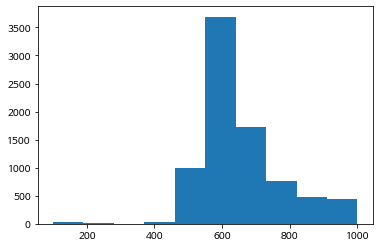

In [ ]:
plt.hist(df_cs['신용점수'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


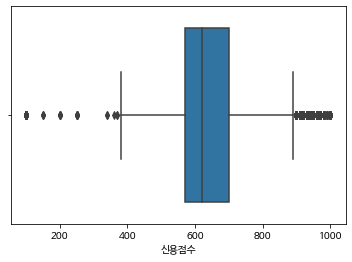

In [ ]:
sns.boxplot(df_cs['신용점수'])
plt.show()

#### **기대출금액**

**결측치 : 1203995개**

In [ ]:
print(df[df['기대출금액'].isna()]['유저 번호'].unique().tolist())

[753869.0, 253902.0, 151077.0, 598065.0, 468123.0, 704915.0, 834243.0, 417662.0, 175502.0, 294374.0, 160965.0, 236072.0, 62966.0, 485326.0, 29389.0, 96166.0, 343546.0, 34488.0, 17700.0, 388295.0, 540893.0, 91901.0, 638473.0, 714123.0, 453181.0, 833502.0, 58969.0, 481833.0, 247443.0, 821503.0, 711059.0, 636249.0, 379874.0, 412502.0, 466584.0, 671499.0, 681803.0, 841914.0, 459287.0, 831755.0, 247776.0, 349073.0, 599229.0, 404344.0, 718173.0, 171175.0, 116057.0, 838615.0, 171546.0, 65119.0, 571368.0, 3798.0, 186871.0, 863031.0, 388668.0, 592780.0, 56531.0, 1372.0, 141607.0, 660743.0, 521784.0, 52146.0, 213647.0, 629950.0, 15165.0, 223357.0, 849743.0, 859114.0, 298926.0, 437905.0, 163700.0, 128837.0, 788666.0, 276602.0, 647697.0, 29602.0, 860719.0, 101820.0, 224966.0, 723542.0, 576101.0, 832221.0, 94026.0, 435727.0, 146972.0, 182117.0, 106930.0, 31993.0, 592443.0, 172554.0, 775281.0, 820386.0, 454171.0, 513780.0, 381425.0, 755409.0, 865277.0, 100676.0, 856384.0, 245213.0, 193073.0, 819258.

In [ ]:
len(df[df['기대출금액'].isna()]['유저 번호'].unique())

21639

#### **성별 제거, 연령**

In [ ]:
df.drop(['성별'], axis=1, inplace=True)

In [ ]:
print(df[df['연령'].isna()]['유저 번호'].unique().tolist())

[811237.0, 534412.0, 585687.0, 443998.0, 835134.0, 339480.0, 471614.0, 527274.0, 406128.0, 539065.0, 736529.0, 717936.0, 200730.0, 452491.0, 39354.0, 429359.0, 812207.0, 458893.0, 93381.0, 238627.0, 675130.0, 655040.0, 294076.0, 508419.0, 806960.0, 469207.0, 503586.0, 728575.0, 645738.0, 521879.0, 782276.0, 68912.0, 421114.0, 232393.0, 483983.0, 374412.0, 161247.0, 388507.0, 615831.0, 874411.0, 790934.0, 852758.0, 276059.0, 635983.0, 429434.0, 405110.0, 495296.0, 830929.0, 423895.0, 772009.0, 307607.0, 281541.0, 645812.0, 711221.0, 874682.0, 217099.0, 217857.0, 401739.0, 739527.0, 284109.0, 768827.0, 73428.0, 594765.0, 771047.0, 811097.0, 596268.0, 238686.0, 680486.0, 63477.0, 71207.0, 809221.0, 634131.0, 391391.0, 628201.0, 53015.0, 281615.0, 745223.0, 443027.0, 266957.0, 208307.0, 820796.0, 524687.0, 563319.0, 35705.0, 127635.0, 212094.0, 254472.0, 245775.0, 165753.0, 659979.0, 353925.0, 443566.0, 435421.0, 806236.0, 392993.0, 101453.0, 864247.0, 349810.0, 329247.0, 144480.0, 575075.

In [ ]:
df.loc[df['연령'].isna(), '연령'] = '알수없음'

In [ ]:
df.loc[df['연령대'].isna(), '연령대'] = '알수없음'

#### **MICE를 통한 기대출금액 결측치 해결**

**결측 값을 회귀하는 방식으로 처리하기 때문에 이 방식은 수치형 변수에만 사용**

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
df.shape

(13519842, 24)

In [ ]:
df_mice = df.copy()

In [ ]:
df_mice.columns

Index(['신청서 번호', '한도조회 일시', '금융사 번호', '상품 번호', '승인한도', '승인금리', '신청 여부(타겟)',
       '유저 번호', '생성일시', '신용점수', '연소득', '근로형태', '고용형태', '주거소유형태', '대출희망금액',
       '대출목적', '기대출수', '기대출금액', '날짜', '연령', '근속월수', '연령대', '신용등급', '개인회생 종류'],
      dtype='object')

In [ ]:
df_mice = df_mice[['연소득','대출희망금액','기대출수','기대출금액','근속월수']]

In [ ]:
imputer_mice = IterativeImputer(random_state=42)
df_mice = imputer_mice.fit_transform(df_mice)

In [ ]:
df_mice.shape

(13519842, 5)

In [ ]:
df[['연소득','대출희망금액','기대출수','기대출금액','근속월수']].head()

,연소득,대출희망금액,기대출수,기대출금액,근속월수
0,24000000.0,25000000.0,2.0,15000000.0,4.0
1,24000000.0,25000000.0,2.0,15000000.0,4.0
2,24000000.0,25000000.0,2.0,15000000.0,4.0
3,24000000.0,25000000.0,2.0,15000000.0,4.0
4,24000000.0,25000000.0,2.0,15000000.0,4.0


In [ ]:
df_mice = pd.DataFrame(df_mice, columns = ['연소득','대출희망금액','기대출수','기대출금액','근속월수'])
df_mice.head()

,연소득,대출희망금액,기대출수,기대출금액,근속월수
0,24000000.0,25000000.0,2.0,15000000.0,4.0
1,24000000.0,25000000.0,2.0,15000000.0,4.0
2,24000000.0,25000000.0,2.0,15000000.0,4.0
3,24000000.0,25000000.0,2.0,15000000.0,4.0
4,24000000.0,25000000.0,2.0,15000000.0,4.0


In [ ]:
sns.kdeplot(df.loc[(df['기대출수'] == 1), '기대출금액']  , c = 'r' , label='No imputation')
sns.kdeplot(df_mice.loc[(df_mice['기대출수'] == 1), '기대출금액'] , c = 'g' , label='MICE imputation')
plt.show()

In [ ]:
df.drop(['연소득','대출희망금액','기대출수','기대출금액','근속월수'], axis=1, inplace=True)
df = pd.concat([df, df_mice], axis=1)

In [ ]:
# df.to_csv(ROOT + 'DoingNaN.csv', index=False)

In [ ]:
# 결측치 확인
df.isna().sum().sort_values(ascending=False)

신청 여부(타겟)    3255466
신용등급         1508618
신용점수         1311225
근속월수               0
근로형태               0
한도조회 일시            0
금융사 번호             0
상품 번호              0
승인한도               0
승인금리               0
유저 번호              0
생성일시               0
고용형태               0
기대출금액              0
주거소유형태             0
대출목적               0
날짜                 0
연령                 0
연령대                0
개인회생 종류            0
연소득                0
대출희망금액             0
기대출수               0
신청서 번호             0
dtype: int64

#### **파생변수 추가**

**한 유저에게 상품 기준으로 누적으로 추천 뜬 수**

In [ ]:
df = df.sort_values(['유저 번호', '생성일시'], ascending = [True, True])

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,날짜,연령,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수
4752633,248576,2022-05-21 23:41:10,35,168,28000000.0,16.8,0.0,9.0,2022-05-21 23:41:09,810.0,...,2022-05-21,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0
4752634,248576,2022-05-21 23:41:10,43,246,20000000.0,12.9,0.0,9.0,2022-05-21 23:41:09,810.0,...,2022-05-21,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0
4752635,248576,2022-05-21 23:41:11,37,206,26000000.0,16.9,0.0,9.0,2022-05-21 23:41:09,810.0,...,2022-05-21,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0
4752636,248576,2022-05-21 23:41:09,38,134,16000000.0,7.5,0.0,9.0,2022-05-21 23:41:09,810.0,...,2022-05-21,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0
4752637,248576,2022-05-21 23:41:09,59,150,20000000.0,15.0,0.0,9.0,2022-05-21 23:41:09,810.0,...,2022-05-21,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703524,1543548,2022-05-10 20:40:53,59,150,28000000.0,12.8,0.0,879697.0,2022-05-10 20:40:52,NaN,...,2022-05-10,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0
6703525,1543548,2022-05-10 20:40:55,12,35,23000000.0,9.2,0.0,879697.0,2022-05-10 20:40:52,NaN,...,2022-05-10,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0
6703526,1543548,2022-05-10 20:41:11,34,215,34000000.0,11.9,0.0,879697.0,2022-05-10 20:40:52,NaN,...,2022-05-10,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0
6703528,1543548,2022-05-10 20:40:53,10,65,70000000.0,12.4,0.0,879697.0,2022-05-10 20:40:52,NaN,...,2022-05-10,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0


In [ ]:
cumcount = pd.DataFrame(df.groupby(['유저 번호', '상품 번호'], as_index = False).cumcount()+1)
cumcount.columns = ['상품 누적 추천 수']
df = pd.concat([df, cumcount], axis = 1)
df

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
2022-10-11 02:51:40,783 [INFO]  NumExpr defaulting to 4 threads.


,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,연령,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수
4752633,248576,2022-05-21 23:41:10,35,168,28000000.0,16.8,0.0,9.0,2022-05-21 23:41:09,810.0,...,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0,1
4752634,248576,2022-05-21 23:41:10,43,246,20000000.0,12.9,0.0,9.0,2022-05-21 23:41:09,810.0,...,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0,1
4752635,248576,2022-05-21 23:41:11,37,206,26000000.0,16.9,0.0,9.0,2022-05-21 23:41:09,810.0,...,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0,1
4752636,248576,2022-05-21 23:41:09,38,134,16000000.0,7.5,0.0,9.0,2022-05-21 23:41:09,810.0,...,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0,1
4752637,248576,2022-05-21 23:41:09,59,150,20000000.0,15.0,0.0,9.0,2022-05-21 23:41:09,810.0,...,27.0,20대,4등급,CASE1,29000000.0,15000000.0,1.0,2.603670e+07,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703524,1543548,2022-05-10 20:40:53,59,150,28000000.0,12.8,0.0,879697.0,2022-05-10 20:40:52,NaN,...,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0,1
6703525,1543548,2022-05-10 20:40:55,12,35,23000000.0,9.2,0.0,879697.0,2022-05-10 20:40:52,NaN,...,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0,1
6703526,1543548,2022-05-10 20:41:11,34,215,34000000.0,11.9,0.0,879697.0,2022-05-10 20:40:52,NaN,...,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0,1
6703528,1543548,2022-05-10 20:40:53,10,65,70000000.0,12.4,0.0,879697.0,2022-05-10 20:40:52,NaN,...,61.0,60대,NaN,CASE1,70000000.0,200000000.0,0.0,0.000000e+00,1.0,1


In [ ]:
# 다시 원상태로 데이터 정렬
df = df.sort_index()

**한 신청서 번호 안에 추천 수 칼럼 추가**

In [ ]:
num_app = pd.DataFrame(df['신청서 번호'].value_counts())
num_app.reset_index(inplace = True)
num_app.columns = ['신청서 번호', '추천 수']
num_app

,신청서 번호,추천 수
0,1650417,80
1,52259,79
2,410768,79
3,160179,78
4,2106574,78
...,...,...
968722,814119,1
968723,789547,1
968724,219982,1
968725,953467,1


In [ ]:
df = pd.merge(df, num_app, on = '신청서 번호')
df.head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,6,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13519837,1428218,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN,478802.0,2022-06-03 12:01:47,610.0,...,50대,7등급,CASE1,45000000.0,50000000.0,2.0,56000000.0,39.0,2,39
13519838,1428218,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN,478802.0,2022-06-03 12:01:47,610.0,...,50대,7등급,CASE1,45000000.0,50000000.0,2.0,56000000.0,39.0,2,39
13519839,1428218,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN,478802.0,2022-06-03 12:01:47,610.0,...,50대,7등급,CASE1,45000000.0,50000000.0,2.0,56000000.0,39.0,2,39
13519840,1428218,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN,478802.0,2022-06-03 12:01:47,610.0,...,50대,7등급,CASE1,45000000.0,50000000.0,2.0,56000000.0,39.0,3,39


In [ ]:
# 신용점수로 신용등급 변수 생성
bins = [0,334,453,529,629,697,767,831,890,941,1000]
labels = ['10등급','9등급','8등급','7등급','6등급','5등급','4등급','3등급','2등급','1등급']

df['신용등급'] = pd.cut(df['신용점수'], bins=bins, labels=labels)

In [ ]:
df.isna().sum()

신청서 번호              0
한도조회 일시             0
금융사 번호              0
상품 번호               0
승인한도                0
승인금리                0
신청 여부(타겟)     3255466
유저 번호               0
생성일시                0
신용점수          1311225
근로형태                0
고용형태                0
주거소유형태              0
대출목적                0
날짜                  0
연령                  0
연령대                 0
신용등급          1311225
개인회생 종류             0
연소득                 0
대출희망금액              0
기대출수                0
기대출금액               0
근속월수                0
상품 누적 추천 수          0
추천 수                0
dtype: int64

In [ ]:
df['신용등급'] = df['신용등급'].astype('str')
df['신용등급'].replace("nan", np.nan, inplace=True)

In [ ]:
df['신용등급'].fillna('알수없음', inplace=True)

In [ ]:
df.isna().sum()

신청서 번호              0
한도조회 일시             0
금융사 번호              0
상품 번호               0
승인한도                0
승인금리                0
신청 여부(타겟)     3255466
유저 번호               0
생성일시                0
신용점수          1311225
근로형태                0
고용형태                0
주거소유형태              0
대출목적                0
날짜                  0
연령                  0
연령대                 0
신용등급                0
개인회생 종류             0
연소득                 0
대출희망금액              0
기대출수                0
기대출금액               0
근속월수                0
상품 누적 추천 수          0
추천 수                0
dtype: int64

In [ ]:
# df.to_csv(ROOT + 'JustDoit.csv', index=False)

#### **Datawig로 신용등급 결측치 해결**

In [ ]:
!pip install datawig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 메서드 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import datawig

In [ ]:
# # 코랩 구글 드라이브 연동
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ROOT = '/content/drive/MyDrive/2022빅콘/data/'

# # 데이터 불러오기
# df = pd.read_csv(ROOT + 'JustDoit.csv')

In [ ]:
# # 신용점수로 신용등급 변수 생성
# bins = [0,334,453,529,629,697,767,831,890,941,1000]
# labels = ['10등급','9등급','8등급','7등급','6등급','5등급','4등급','3등급','2등급','1등급']

# df['신용등급'] = pd.cut(df['신용점수'], bins=bins, labels=labels)

In [ ]:
df.shape

(13519842, 26)

In [ ]:
df['신용등급'].replace("알수없음", np.nan, inplace=True)

In [ ]:
df[df['신용등급'].isna()].shape

(1311225, 26)

In [ ]:
df.isna().sum()

신청서 번호              0
한도조회 일시             0
금융사 번호              0
상품 번호               0
승인한도                0
승인금리                0
신청 여부(타겟)     3255466
유저 번호               0
생성일시                0
신용점수          1311225
근로형태                0
고용형태                0
주거소유형태              0
대출목적                0
날짜                  0
연령                  0
연령대                 0
신용등급          1311225
개인회생 종류             0
연소득                 0
대출희망금액              0
기대출수                0
기대출금액               0
근속월수                0
상품 누적 추천 수          0
추천 수                0
dtype: int64

In [ ]:
df['신용등급'].value_counts()

6등급     2678159
5등급     2182402
7등급     2035413
4등급     1604487
3등급     1268180
2등급     1173878
1등급     1145376
8등급      112175
9등급        4697
10등급       3850
Name: 신용등급, dtype: int64

In [ ]:
df_wig = df[df['유저 번호'].duplicated() == False]
df_wig

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
35,830336,2022-06-07 12:08:11,37,206,15000000.0,19.9,NaN,345273.0,2022-06-07 12:08:09,700.0,...,40대,5등급,CASE1,60000000.0,15000000.0,3.0,86000000.0,5.0,10,1
36,728546,2022-06-07 21:16:43,19,231,50000000.0,14.5,NaN,3058.0,2022-06-07 21:16:43,910.0,...,30대,2등급,CASE1,39000000.0,14000000.0,0.0,0.0,64.0,2,14
50,1641986,2022-06-07 19:28:15,21,196,12000000.0,9.0,NaN,181137.0,2022-06-07 19:28:13,NaN,...,20대,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26
76,937515,2022-06-07 05:12:28,59,251,13000000.0,6.9,NaN,197454.0,2022-06-07 05:12:28,550.0,...,40대,7등급,CASE1,41000000.0,5000000.0,2.0,42000000.0,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13519313,1503385,2022-06-03 15:22:22,49,39,15000000.0,16.2,NaN,564079.0,2022-06-03 15:22:03,510.0,...,40대,8등급,CASE1,25000000.0,30000000.0,1.0,9000000.0,6.0,1,1
13519403,331277,2022-06-03 10:31:47,37,206,23000000.0,19.9,NaN,364214.0,2022-06-03 10:31:45,520.0,...,30대,8등급,CASE1,32000000.0,2000000.0,0.0,0.0,35.0,1,3
13519455,231674,2022-06-03 20:22:39,64,254,12000000.0,15.6,NaN,77460.0,2022-06-03 20:22:37,690.0,...,30대,6등급,CASE1,18000000.0,10000000.0,4.0,26000000.0,46.0,1,1
13519713,1125770,2022-06-03 11:52:26,19,231,21000000.0,14.5,NaN,876482.0,2022-06-03 11:52:25,690.0,...,30대,6등급,CASE1,35000000.0,5000000.0,5.0,23000000.0,2.0,1,6


In [ ]:
df_wig.columns

Index(['신청서 번호', '한도조회 일시', '금융사 번호', '상품 번호', '승인한도', '승인금리', '신청 여부(타겟)',
       '유저 번호', '생성일시', '신용점수', '근로형태', '고용형태', '주거소유형태', '대출목적', '날짜', '연령',
       '연령대', '신용등급', '개인회생 종류', '연소득', '대출희망금액', '기대출수', '기대출금액', '근속월수',
       '상품 누적 추천 수', '추천 수'],
      dtype='object')

In [ ]:
imputer = datawig.SimpleImputer(input_columns=['기대출수', '연소득', '기대출금액', '근속월수', '개인회생 종류', '연령대', '주거소유형태', '고용형태', '근로형태'],
                                output_column='신용등급')

In [ ]:
imputer.fit(train_df=df_wig, num_epochs=50, batch_size=1024, test_split=0.2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
2022-10-11 13:26:37,527 [INFO]  NumExpr defaulting to 4 threads.
INFO:root:
========== start: fit model
2022-10-11 13:28:27,354 [INFO]  
========== start: fit model
2022-10-11 13:28:27,362 [WARNING]  Already bound, ignoring bind()
INFO:root:Epoch[0] Batch [0-105]	Speed: 1846.74 samples/sec	cross-entropy=1.752460	신용등급-accuracy=0.338747
2022-10-11 13:29:26,168 [INFO]  Epoch[0] Batch [0-105]	Speed: 1846.74 samples/sec	cross-entropy=1.752460	신용등급-accuracy=0.338747
INFO:root:Epoch[0] Train-cross-entropy=1.727933
2022-10-11 13:30:21,389 [INFO]  Epoch[0] Train-cross-entrop

In [ ]:
null_train = df_wig[df_wig['신용등급'].isna()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

In [ ]:
imputed_train

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수,신용등급_imputed,신용등급_imputed_proba
50,1641986,2022-06-07 19:28:15,21,196,12000000.0,9.0,NaN,181137.0,2022-06-07 19:28:13,NaN,...,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,7등급,0.272885
149,2083853,2022-06-07 16:12:42,29,75,19000000.0,9.4,NaN,158340.0,2022-06-07 16:12:22,NaN,...,CASE1,26000000.0,5000000.0,0.0,0.0,6.0,1,4,7등급,0.309207
853,1966421,2022-06-07 14:46:12,21,196,10000000.0,12.0,NaN,497469.0,2022-06-07 14:46:10,NaN,...,CASE1,55000000.0,100000000.0,0.0,0.0,30.0,2,46,7등급,0.215429
969,990662,2022-06-07 20:10:32,25,169,3000000.0,14.9,NaN,46253.0,2022-06-07 20:10:30,NaN,...,CASE1,32000000.0,3000000.0,0.0,0.0,49.0,1,41,2등급,0.182756
1010,1963697,2022-06-07 22:03:52,13,262,27000000.0,18.6,NaN,250916.0,2022-06-07 22:03:52,NaN,...,CASE1,0.0,10000000.0,0.0,0.0,0.0,1,12,5등급,0.272393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518574,320909,2022-06-03 20:45:15,51,247,48000000.0,13.8,NaN,405503.0,2022-06-03 20:45:14,NaN,...,CASE1,34000000.0,120000000.0,0.0,0.0,26.0,1,70,7등급,0.254235
13519179,279380,2022-06-03 09:24:43,34,243,33000000.0,16.9,NaN,303226.0,2022-06-03 09:24:41,NaN,...,CASE1,60000000.0,20000000.0,0.0,0.0,2.0,1,10,6등급,0.237060
13519308,1115578,2022-06-03 14:49:54,54,235,6000000.0,18.5,NaN,152246.0,2022-06-03 14:49:52,NaN,...,CASE1,32000000.0,5000000.0,0.0,0.0,10.0,1,1,7등급,0.289377
13519310,1810450,2022-06-03 15:26:51,61,92,24000000.0,16.8,NaN,878992.0,2022-06-03 15:26:50,NaN,...,CASE1,24000000.0,3000000.0,0.0,0.0,0.0,1,3,5등급,0.281884


#### **모델로 신용 점수 결측치 채우기**

In [ ]:
df_credit = df_wig[['기대출수', '기대출금액', '연소득', '근속월수', '개인회생 종류', '연령대', '주거소유형태', '고용형태', '근로형태','신용점수']]

In [ ]:
df_credit.corr()

,기대출수,기대출금액,연소득,근속월수,신용점수
기대출수,1.000000,0.412306,0.005363,0.129961,-0.240029
기대출금액,0.412306,1.000000,0.069995,0.272412,0.094809
연소득,0.005363,0.069995,1.000000,0.101885,0.053122
근속월수,0.129961,0.272412,0.101885,1.000000,0.106833
신용점수,-0.240029,0.094809,0.053122,0.106833,1.000000


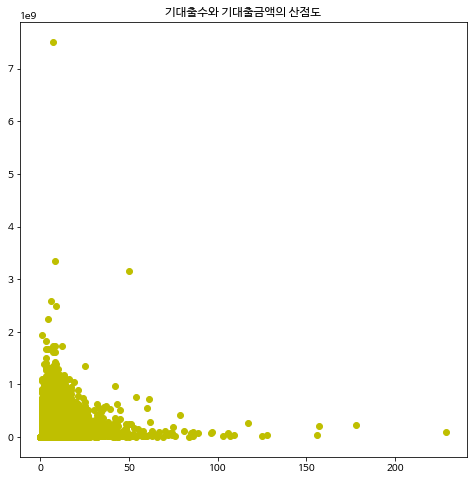

In [ ]:
plt.figure(figsize=(8,8))
plt.title('기대출수와 기대출금액의 산점도')
plt.scatter(df_credit['기대출수'], df_credit['기대출금액'], c='y')
plt.show()

**기대출수는 기대출금액과 관련이 있지만 기대출금액은 신용점수와 관련이 없어 사용하지 않는다 <br>
연소득도 관련성 없어 제거한다**

In [ ]:
df_credit.drop(['기대출금액','연소득'], axis=1, inplace=True)

**1. 기대출수**

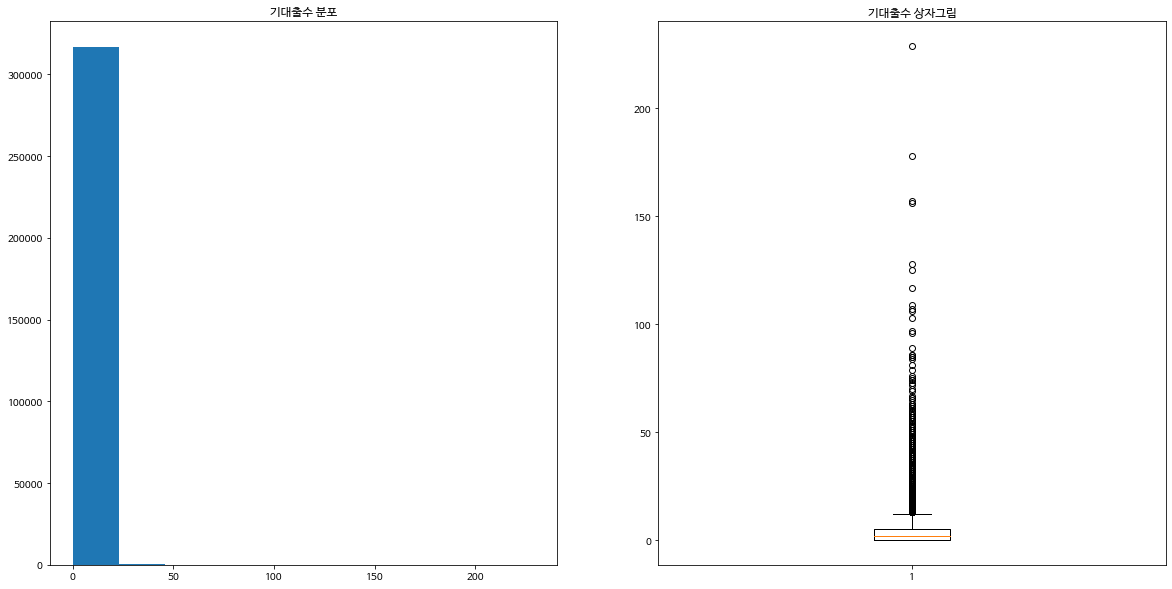

In [ ]:
# 기대출수
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('기대출수 분포')
plt.hist(df_credit['기대출수'])

plt.subplot(1,2,2)
plt.title('기대출수 상자그림')
plt.boxplot(df_credit['기대출수'])

plt.show()

In [ ]:
print('왜도 값 : {}'.format(df_credit['기대출수'].skew()))
print('첨도 값 : {}'.format(df_credit['기대출수'].kurt()))

왜도 값 : 5.036486988861912
첨도 값 : 125.19157997105381


**기대출수 로그 변환 필요해보임**

In [ ]:
df_credit['기대출수'] = np.log1p(df_credit['기대출수'])

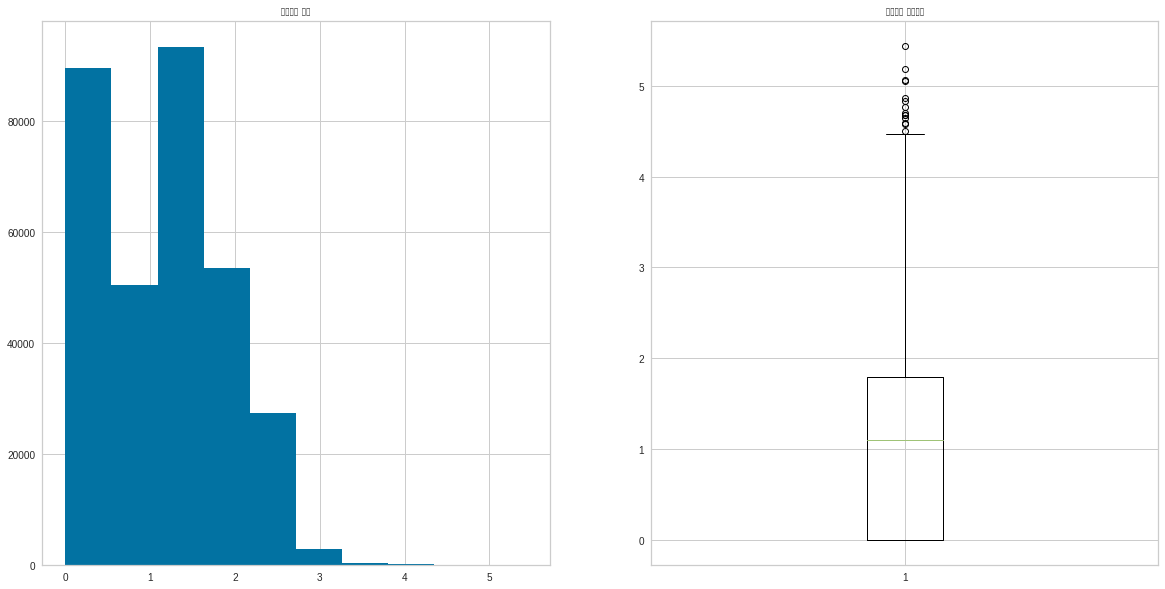

로그 변환 후 왜도 값 : 0.09777526231111214
로그 변환 후 첨도 값 : -1.069292343392057


In [ ]:
# 기대출수
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('기대출수 분포')
plt.hist(df_credit['기대출수'])

plt.subplot(1,2,2)
plt.title('기대출수 상자그림')
plt.boxplot(df_credit['기대출수'])

plt.show()

print('로그 변환 후 왜도 값 : {}'.format(df_credit['기대출수'].skew()))
print('로그 변환 후 첨도 값 : {}'.format(df_credit['기대출수'].kurt()))

**2. 근속월수**

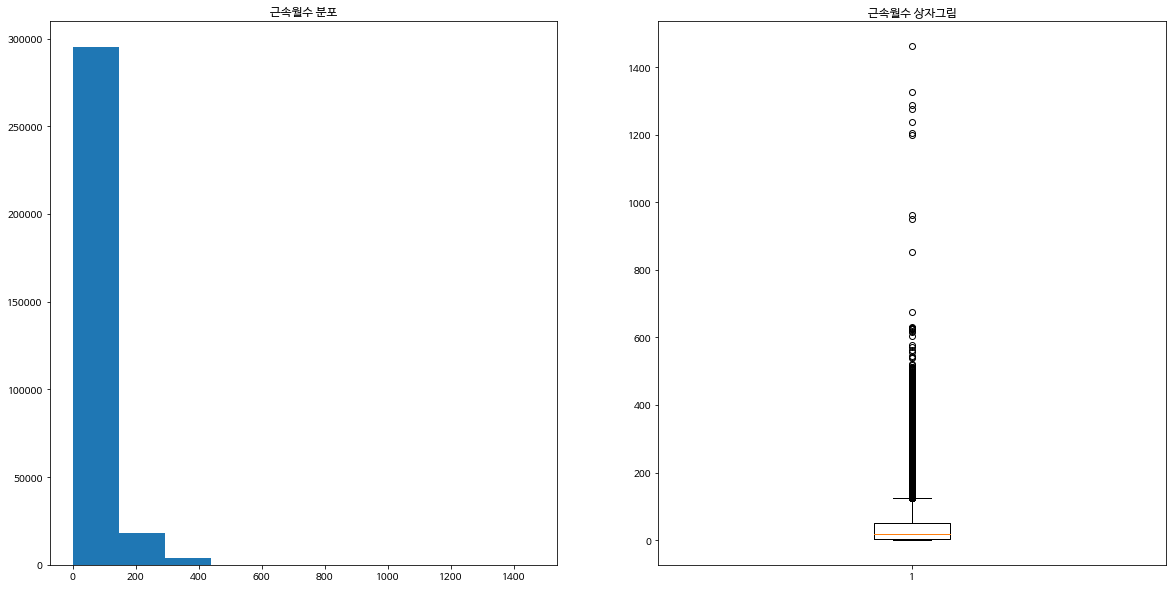

In [ ]:
# 근속월수
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('근속월수 분포')
plt.hist(df_credit['근속월수'])

plt.subplot(1,2,2)
plt.title('근속월수 상자그림')
plt.boxplot(df_credit['근속월수'])

plt.show()

In [ ]:
print('왜도 값 : {}'.format(df_credit['근속월수'].skew()))
print('첨도 값 : {}'.format(df_credit['근속월수'].kurt()))

왜도 값 : 2.7883367317341037
첨도 값 : 11.77700763127613


In [ ]:
df_credit['근속월수'] = np.log1p(df_credit['근속월수'])

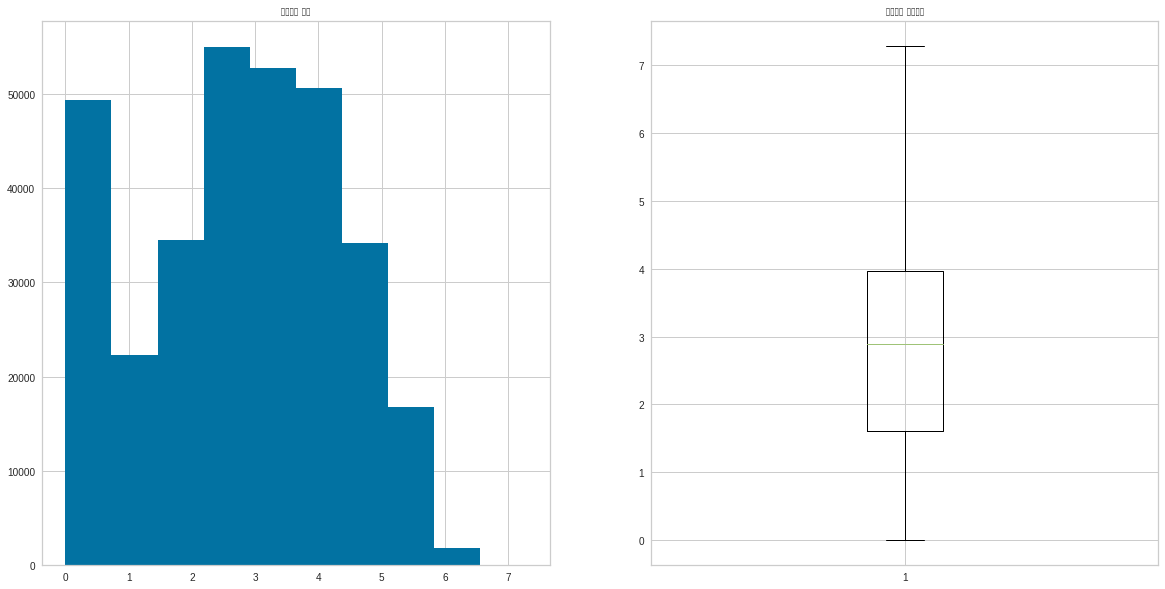

로그 변환 후 왜도 값 : -0.23089947987494774
로그 변환 후 첨도 값 : -0.8157954295479222


In [ ]:
# 근속월수
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('근속월수 분포')
plt.hist(df_credit['근속월수'])

plt.subplot(1,2,2)
plt.title('근속월수 상자그림')
plt.boxplot(df_credit['근속월수'])

plt.show()

print('로그 변환 후 왜도 값 : {}'.format(df_credit['근속월수'].skew()))
print('로그 변환 후 첨도 값 : {}'.format(df_credit['근속월수'].kurt()))

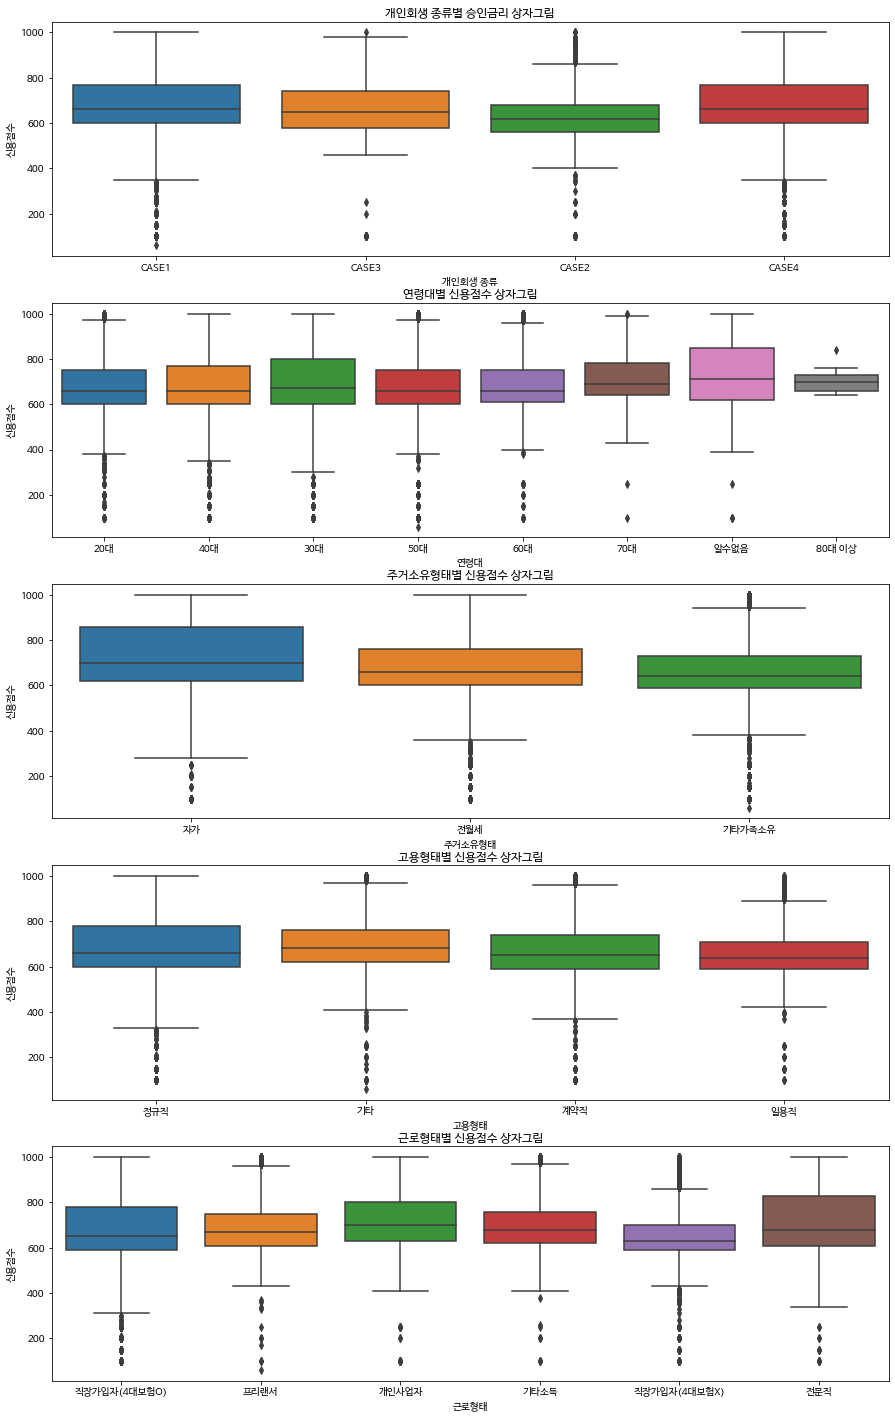

In [ ]:
# 범주형, 타겟 데이터 관계
plt.figure(figsize=(15,25))

plt.subplot(5,1,1)
plt.title('개인회생 종류별 승인금리 상자그림')
sns.boxplot(x='개인회생 종류',y='신용점수',data=df_credit)

plt.subplot(5,1,2)
plt.title('연령대별 신용점수 상자그림')
sns.boxplot(x='연령대',y='신용점수',data=df_credit)

plt.subplot(5,1,3)
plt.title('주거소유형태별 신용점수 상자그림')
sns.boxplot(x='주거소유형태',y='신용점수',data=df_credit)

plt.subplot(5,1,4)
plt.title('고용형태별 신용점수 상자그림')
sns.boxplot(x='고용형태',y='신용점수',data=df_credit)

plt.subplot(5,1,5)
plt.title('근로형태별 신용점수 상자그림')
sns.boxplot(x='근로형태',y='신용점수',data=df_credit)

plt.show()

##### **AutoML**

In [ ]:
from pycaret.regression import *

In [ ]:
# 데이터 완성
df_credit = df_wig[['기대출수', '기대출금액', '연소득', '근속월수', '개인회생 종류', '연령대', '주거소유형태', '고용형태', '근로형태','신용점수']]
df_credit.drop(['기대출금액','연소득'], axis=1, inplace=True)
df_credit['기대출수'] = np.log1p(df_credit['기대출수'])
df_credit['근속월수'] = np.log1p(df_credit['근속월수'])

In [ ]:
# 로그 변환만 함
exp_reg = setup(data = df_credit,  target = '신용점수')

,Description,Value
0,session_id,7040
1,Target,신용점수
2,Original Data,"(317458, 8)"
3,Missing Values,True
4,Numeric Features,2
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(186646, 27)"


INFO:logs:create_model_container: 0
2022-10-11 17:07:58,567 [INFO]  create_model_container: 0
INFO:logs:master_model_container: 0
2022-10-11 17:07:58,573 [INFO]  master_model_container: 0
INFO:logs:display_container: 1
2022-10-11 17:07:58,576 [INFO]  display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='신용점수',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='m...
                ('scaling', 'passthrough'),

In [ ]:
best_model = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,90.9620,13426.7060,115.8710,0.1954,0.1773,0.1394,0.799
gbr,Gradient Boosting Regressor,91.5934,13535.9409,116.3415,0.1889,0.1781,0.1405,8.372
br,Bayesian Ridge,94.6443,14259.9853,119.4129,0.1455,0.1822,0.1451,0.195
ridge,Ridge Regression,94.6471,14260.0274,119.4131,0.1455,0.1822,0.1451,0.044
lr,Linear Regression,94.6474,14260.0427,119.4132,0.1455,0.1822,0.1451,0.375
lar,Least Angle Regression,94.6474,14260.0427,119.4132,0.1455,0.1822,0.1451,0.052
lasso,Lasso Regression,94.9871,14408.1055,120.0312,0.1366,0.1834,0.1460,0.061
huber,Huber Regressor,93.2578,14439.8092,120.1631,0.1347,0.1818,0.1406,2.879
ada,AdaBoost Regressor,96.6461,14694.6624,121.2174,0.1194,0.1836,0.1471,3.074
omp,Orthogonal Matching Pursuit,95.9798,14802.2656,121.6621,0.1130,0.1855,0.1474,0.047


INFO:logs:create_model_container: 18
2022-10-11 17:22:13,671 [INFO]  create_model_container: 18
INFO:logs:master_model_container: 18
2022-10-11 17:22:13,674 [INFO]  master_model_container: 18
INFO:logs:display_container: 2
2022-10-11 17:22:13,679 [INFO]  display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7040, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
2022-10-11 17:22:13,683 [INFO]  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0

In [ ]:
models()

INFO:logs:gpu_param set to False
2022-10-11 17:28:23,700 [INFO]  gpu_param set to False
2022-10-11 17:28:23,897 [WARNING]  Wrong xgboost version. Expected xgboost>=1.1.0, got xgboost==0.90
2022-10-11 17:28:23,904 [WARNING]  Couldn't import catboost.CatBoostRegressor


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.6286,13227.4655,115.0107,0.2070,0.1754,0.1386
1,90.4051,13345.2920,115.5218,0.1964,0.1782,0.1393
2,91.8522,13593.0029,116.5890,0.1906,0.1767,0.1398
3,91.7065,13621.1092,116.7095,0.1820,0.1802,0.1416
4,91.0212,13485.9115,116.1289,0.1988,0.1780,0.1398
5,90.3982,13161.0765,114.7217,0.2025,0.1726,0.1368
6,90.7570,13353.0961,115.5556,0.1944,0.1739,0.1374
7,90.4753,13210.6958,114.9378,0.1916,0.1728,0.1369
8,91.0615,13574.5312,116.5098,0.1887,0.1810,0.1411


INFO:logs:create_model_container: 19
2022-10-11 17:29:20,775 [INFO]  create_model_container: 19
INFO:logs:master_model_container: 19
2022-10-11 17:29:20,778 [INFO]  master_model_container: 19
INFO:logs:display_container: 3
2022-10-11 17:29:20,781 [INFO]  display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7040, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
2022-10-11 17:29:20,786 [INFO]  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0

In [ ]:
print(lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7040, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
X_train.head()

,개인회생 종류_CASE1,개인회생 종류_CASE2,개인회생 종류_CASE3,개인회생 종류_CASE4,연령대_20대,연령대_30대,연령대_40대,연령대_50대,연령대_60대,연령대_70대,...,고용형태_일용직,고용형태_정규직,근로형태_개인사업자,근로형태_기타소득,근로형태_전문직,근로형태_직장가입자(4대보험O),근로형태_직장가입자(4대보험X),근로형태_프리랜서,기대출수,근속월수
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0.202022,0.220806
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0.254924,0.245819
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0.000000,0.572703
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.202022,0.245819
4,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0.127462,0.641086


In [ ]:
X_test.shape

(266608, 27)

##### **LGBM**

In [ ]:
from lightgbm import LGBMRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
# 데이터 완성
df_credit = df_wig[['기대출수', '기대출금액', '연소득', '근속월수', '개인회생 종류', '연령대', '주거소유형태', '고용형태', '근로형태','신용점수']]
df_credit.drop(['기대출금액','연소득'], axis=1, inplace=True)
df_credit['기대출수'] = np.log1p(df_credit['기대출수'])
df_credit['근속월수'] = np.log1p(df_credit['근속월수'])

In [ ]:
# 범주형 변수 원핫 인코딩
df_credit = pd.get_dummies(data=df_credit, columns = ['개인회생 종류','연령대','주거소유형태','고용형태','근로형태'])

In [ ]:
# train, test 로 분리
train = df_credit[-df_credit['신용점수'].isna()]
test = df_credit[df_credit['신용점수'].isna()]

In [ ]:
print(train.shape)
print(test.shape)

(266608, 28)
(50850, 28)


In [ ]:
# 세부적으로 분리
X_train = train.drop(['신용점수'], axis=1)
y_train = train[['신용점수']]

X_test = test.drop(['신용점수'], axis=1)
y_test = test[['신용점수']]

In [ ]:
# 수치형 변수
X_train_num = X_train[['기대출수','근속월수']]
X_test_num = X_test[['기대출수','근속월수']]

In [ ]:
# MinMaxScaler 적용
Scaler = MinMaxScaler()

X_train_mm = Scaler.fit_transform(X_train_num)
X_test_mm = Scaler.transform(X_test_num)

X_train_mm = pd.DataFrame(X_train_mm, columns = ['기대출수','근속월수'])
X_test_mm = pd.DataFrame(X_test_mm, columns = ['기대출수','근속월수'])

In [ ]:
# 기존 train, test 데이터 인덱스 초기화
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train.drop(['기대출수','근속월수'], axis=1, inplace=True)
X_test.drop(['기대출수','근속월수'], axis=1, inplace=True)

X_train = pd.concat([X_train, X_train_mm], axis=1)
X_test = pd.concat([X_test, X_test_mm], axis=1)

**모델링**

In [ ]:
clf_lgbm = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                         importance_type='split', learning_rate=0.1, max_depth=-1,
                         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                         n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                         random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                         subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
clf_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = clf_lgbm.predict(X_test)

In [ ]:
# 최종 신용점수 결측치 보간 값
y_pred = pd.DataFrame(np.round(y_pred,-1), columns=['신용점수(보간)'])
y_pred

,신용점수(보간)
0,700.0
1,690.0
2,720.0
3,800.0
4,740.0
...,...
50845,720.0
50846,730.0
50847,700.0
50848,740.0


In [ ]:
user_cred_nan =  pd.DataFrame(df_wig.loc[df_wig['신용점수'].isna(), '유저 번호']).reset_index(drop=True)
user_cred_nan

,유저 번호
0,181137.0
1,158340.0
2,497469.0
3,46253.0
4,250916.0
...,...
50845,405503.0
50846,303226.0
50847,152246.0
50848,878992.0


In [ ]:
new_cred = pd.concat([y_pred,user_cred_nan], axis=1)
new_cred

,신용점수(보간),유저 번호
0,700.0,181137.0
1,690.0,158340.0
2,720.0,497469.0
3,800.0,46253.0
4,740.0,250916.0
...,...,...
50845,720.0,405503.0
50846,730.0,303226.0
50847,700.0,152246.0
50848,740.0,878992.0


In [ ]:
new_cred.loc[new_cred['유저 번호'] == 181137,'신용점수(보간)'].iloc[0]

700.0

In [ ]:
df.head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,2022-06-07 13:05:39,620.0,...,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,6,35


In [ ]:
real = df.copy()

In [ ]:
df['신용점수(보완)'] = df['신용점수']

In [ ]:
# 신용점수 결측치 보완
for i, user in enumerate(new_cred['유저 번호'].tolist()):
    df.loc[real['유저 번호'] == user, '신용점수(보완)'] = new_cred.iloc[i,0]

In [ ]:
df[df['유저 번호'] == 181137].head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,신용점수,...,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수,신용점수(보완)
50,1641986,2022-06-07 19:28:15,21,196,12000000.0,9.0,NaN,181137.0,2022-06-07 19:28:13,NaN,...,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,700.0
51,1641986,2022-06-07 19:28:14,13,262,34000000.0,16.4,NaN,181137.0,2022-06-07 19:28:13,NaN,...,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,700.0
52,1641986,2022-06-07 19:28:14,14,128,10000000.0,12.5,NaN,181137.0,2022-06-07 19:28:13,NaN,...,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,700.0
53,1641986,2022-06-07 19:28:16,12,35,7000000.0,5.3,NaN,181137.0,2022-06-07 19:28:13,NaN,...,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,700.0
54,1641986,2022-06-07 19:28:14,61,92,28000000.0,12.8,NaN,181137.0,2022-06-07 19:28:13,NaN,...,NaN,CASE1,30000000.0,23000000.0,0.0,0.0,2.0,2,26,700.0


In [ ]:
# 보완된 신용점수로 신용등급 변수 생성
bins = [0,334,453,529,629,697,767,831,890,941,1000]
labels = ['10등급','9등급','8등급','7등급','6등급','5등급','4등급','3등급','2등급','1등급']

df['신용등급'] = pd.cut(df['신용점수(보완)'], bins=bins, labels=labels)

In [ ]:
# 기존 신용점수 칼럼 버리기
df.drop(['신용점수'], axis=1, inplace=True)

#### **파생변수 추가**

In [ ]:
df['한도조회 일시'] = pd.to_datetime(df['한도조회 일시'])

In [ ]:
df[['신청서 번호', '금융사 번호', '상품 번호', '신청 여부(타겟)', '유저 번호']] = df[['신청서 번호', '금융사 번호', '상품 번호', '신청 여부(타겟)', '유저 번호']].astype(object)

In [ ]:
exam = df.groupby(['유저 번호','신청서 번호'], as_index = False)['한도조회 일시'].max()
exam.sort_values(['유저 번호', '한도조회 일시'], inplace = True)
exam.reset_index(drop = True, inplace = True)
exam

,유저 번호,신청서 번호,한도조회 일시
0,9.0,248576,2022-05-21 23:41:30
1,11.0,1180616,2022-03-24 10:58:38
2,11.0,1751522,2022-04-20 10:11:18
3,11.0,1521731,2022-06-09 11:25:51
4,11.0,1894024,2022-06-13 21:44:52
...,...,...,...
968722,879693.0,1055525,2022-06-27 10:16:17
968723,879695.0,1774704,2022-05-27 12:51:06
968724,879696.0,2149910,2022-03-14 05:23:49
968725,879696.0,1856758,2022-03-14 05:40:56


In [ ]:
ex = pd.DataFrame(exam.groupby('유저 번호', as_index = False)['신청서 번호'].cumcount() + 1 )
ex.columns = ['조회 횟수']
exam = pd.concat([exam, ex], axis = 1)
exam

,유저 번호,신청서 번호,한도조회 일시,조회 횟수
0,9.0,248576,2022-05-21 23:41:30,1
1,11.0,1180616,2022-03-24 10:58:38,1
2,11.0,1751522,2022-04-20 10:11:18,2
3,11.0,1521731,2022-06-09 11:25:51,3
4,11.0,1894024,2022-06-13 21:44:52,4
...,...,...,...,...
968722,879693.0,1055525,2022-06-27 10:16:17,5
968723,879695.0,1774704,2022-05-27 12:51:06,1
968724,879696.0,2149910,2022-03-14 05:23:49,1
968725,879696.0,1856758,2022-03-14 05:40:56,2


In [ ]:
import time
from tqdm import tqdm

In [ ]:
exam['시간차'] = 0
real_final = pd.DataFrame()
u_list = list(exam['유저 번호'].unique())
for j in tqdm(u_list):
    test = exam[exam['유저 번호'] == j]
    t_max = test.shape[0]
    if test.shape[0] < 2:
        real_final = pd.concat([real_final, test])
    else:
        for i in range(2, t_max + 1):
            a = test[test['조회 횟수'] == i]['한도조회 일시'].values - test[test['조회 횟수'] == i-1]['한도조회 일시'].values
            a = a.astype('timedelta64[h]').astype(int)
            test.loc[test['조회 횟수'] == i, '시간차'] = a
        real_final = pd.concat([real_final, test])
real_final

  0%|          | 0/317458 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 317458/317458 [1:22:57<00:00, 63.78it/s]


,유저 번호,신청서 번호,한도조회 일시,조회 횟수,시간차
0,9.0,248576,2022-05-21 23:41:30,1,0
1,11.0,1180616,2022-03-24 10:58:38,1,0
2,11.0,1751522,2022-04-20 10:11:18,2,647
3,11.0,1521731,2022-06-09 11:25:51,3,1201
4,11.0,1894024,2022-06-13 21:44:52,4,106
...,...,...,...,...,...
968722,879693.0,1055525,2022-06-27 10:16:17,5,311
968723,879695.0,1774704,2022-05-27 12:51:06,1,0
968724,879696.0,2149910,2022-03-14 05:23:49,1,0
968725,879696.0,1856758,2022-03-14 05:40:56,2,0


In [ ]:
df.head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,근로형태,고용형태,주거소유형태,대출목적,날짜,연령,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수,신용점수(보완)
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,6,35,620.0


In [ ]:
real_final.drop(['유저 번호','한도조회 일시'], axis = 1, inplace = True)
df = pd.merge(df, real_final, on = '신청서 번호')
df.head()

,신청서 번호,한도조회 일시,금융사 번호,상품 번호,승인한도,승인금리,신청 여부(타겟),유저 번호,생성일시,근로형태,고용형태,주거소유형태,대출목적,날짜,연령,연령대,신용등급,개인회생 종류,연소득,대출희망금액,기대출수,기대출금액,근속월수,상품 누적 추천 수,추천 수,신용점수(보완),조회 횟수,시간차
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0,7,340
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0,7,340
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0,7,340
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,1,35,620.0,7,340
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982.0,2022-06-07 13:05:39,직장가입자(4대보험O),정규직,자가,대환대출,2022-06-07,27.0,20대,7등급,CASE1,24000000.0,25000000.0,2.0,15000000.0,4.0,6,35,620.0,7,340
